# ASSIGNMENT #1:
# PREDICTING BANK PRODUCT SUBSCRIPTION

Authors:

Hugo Hernández López. ID:  100563523


Manuel Marín Moreno. ID: 100564929

# SET UP

## Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,StratifiedKFold, cross_val_score,RandomizedSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, RobustScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.base import clone
from statsmodels.stats.proportion import proportion_confint
from sklearn.utils._estimator_html_repr import estimator_html_repr
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,  brier_score_loss, log_loss

import lightgbm as lgb
import xgboost as xgb

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import time
import optuna



C:\Users\manuu\AppData\Local\Temp\ipykernel_7828\3888133382.py:16: FutureWarning: Importing from sklearn.utils._estimator_html_repr is deprecated. The tools have been moved to sklearn.utils._repr_html. Be aware that this module is private and may be subject to change in the future. The module _estimator_html_repr will be removed in 1.8.0.
  from sklearn.utils._estimator_html_repr import estimator_html_repr


## Defining constants

In [2]:
PICKLE_MODELING_FILE='bank_23.pkl'
SEED=100563523
np.random.seed(SEED)

In [3]:
model_dataset = pd.read_pickle(PICKLE_MODELING_FILE).reset_index(drop=True)
model_dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


*Note: we add the `reset_index(drop=True)` to ensure that the indexes in the dataframe goes from 0 to 10999*

<a name="simple-eda"></a>
# 1. SIMPLIFIED EDA

In order to get a better understanding of the dataset we are using to train an test our models, we start by undestanding how many features and how many instances we have. For our specific case, we have 17 features and 11000 instances as can be seen in the following cell:

In [4]:
model_dataset.shape

(11000, 17)

Then is important to understand which of these features are categorical and which are numerical. To this end we execute the following cell:

In [5]:
model_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11000 non-null  int64 
 1   job        11000 non-null  object
 2   marital    10917 non-null  object
 3   education  10852 non-null  object
 4   default    11000 non-null  object
 5   balance    11000 non-null  int64 
 6   housing    11000 non-null  object
 7   loan       11000 non-null  object
 8   contact    11000 non-null  object
 9   day        11000 non-null  int64 
 10  month      11000 non-null  object
 11  duration   11000 non-null  int64 
 12  campaign   11000 non-null  int64 
 13  pdays      11000 non-null  int64 
 14  previous   11000 non-null  int64 
 15  poutcome   11000 non-null  object
 16  deposit    11000 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Based on the previous information, we can see that most of the features has no null values, except the `marital` and the `education` ones, which have 83 (11000-10917=83) and 148 (11000-10852=148) null values, respectively. For these two variables we will need to cunduct some imputation which is explained in further sections. We do not conduct it here because we do encoding, imputation and standarization using pipelinies.

Based on the previous information we could say that there are 7 numerical features and 10 categorical. However, the classification of the variables depends on the use we make of them rather than its data type. In the case of the `day`, although the variable's type is integer, the variable is categorical rather than numerical.

Therefore, we classfy the variables as follows:

- Categorical-Nominal
  - `job`
  - `marital`
  - `contact`
  - `poutcome`
- Categorical-Ordinal
  - `day`
  - `month`
  - `education`

*Note: we consider education as an ordinal value because primary<secondary<...*

- Categorical-Binary
  - `default`
  - `housing`
  - `loan`       
  
- Numerical
  - `age`
  - `balance`
  - `duration`
  - `campaign`
  - `pdays`
  - `previous`       

*Note: we exclude the feature `deposit` because it is our target variable. However, it is a categorical variable. Therefore we are in a classification problem.*


In the case of the categorical values, it is important to identify which variables have a high cardinality. To this end, we run the following cell:

In [6]:
cat_vars=['job','marital','education','default','housing','loan','contact','day','month','poutcome']
cardinality = model_dataset[cat_vars].nunique().sort_values(ascending=False)
print(cardinality)

day          31
job          12
month        12
education     4
poutcome      4
marital       3
contact       3
loan          2
default       2
housing       2
dtype: int64


Now we want to see which are the differnt values these categorcial variables have:

In [7]:
unique_vals = model_dataset[cat_vars].apply(lambda x: x.unique())
print(unique_vals)

job          [admin., technician, services, management, ret...
marital                      [married, single, divorced, None]
education        [secondary, tertiary, primary, unknown, None]
default                                              [no, yes]
housing                                              [yes, no]
loan                                                 [no, yes]
contact                         [unknown, cellular, telephone]
day          [5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 20, 21...
month        [may, jun, jul, aug, oct, nov, dec, jan, feb, ...
poutcome                    [unknown, other, failure, success]
dtype: object


We can see that the categorical features with a high cardinality are `day`, `job` and `month`. In the case of the `day` feature there is no problem bacuse they are already encoded as an integer, thus avoiding the creation of 31 different columns if we'd use one-hot encoding. But, in the case of `job` and `month` things change. Both features have a moderate cardinality (12 different values) that can be handled by one-hot encoding but, for this job, we also explore other ways of encoding it.

We also need to explore whether there is any constant or identification (ID) feature. These two types of features do not provide any valuable information to the models since they do not allow finding any pattern related to the classes. Therefore, we execute the following cell to ensure we do not have these types of features:

In [8]:
def check_const_ids(df):
    constantes = []
    ids = []

    for col in df.columns:
        n_unicos = df[col].nunique()

        if n_unicos == 1:
            constantes.append(col)

        elif n_unicos == len(df):
            ids.append(col)

    print(f"Constants: {constantes}")
    print(f"Posible IDs: {ids}")

check_const_ids(model_dataset)

Constants: []
Posible IDs: []


As we are facing a classification problem, the next step is to explore the distributions of the data inside the dataset. To this end we make several plots. First we see which is the distribution of the target variable in the dataset:

## Deposit distribution

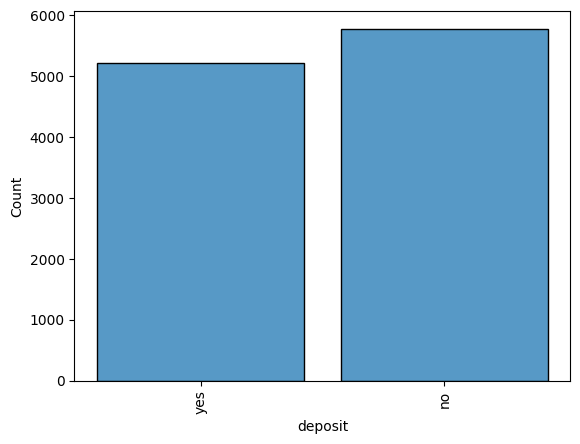

deposit
no     52.545455
yes    47.454545
Name: proportion, dtype: float64


In [9]:
sns.histplot(data=model_dataset, x="deposit", shrink=0.85, discrete=True)
plt.xticks(rotation=90)
plt.show()
props = model_dataset['deposit'].value_counts(normalize=True) * 100
print(props)

The data is fairly balanced. Therefore, we don't need to do anything to ensure the target variable has a similar number of different classes.

## `pdays` analysis

Now we are analysing the feature `pdays` because this variable includes two types of information in the same column. This variable not only contains temporal information (which is numerical) but also about the state of this contact. If the customer has never been contacted or this information is not available, this feature will have a value of -1.

The problem is that this value is very close to a client which could be contacted one day ago (1) or even today(0). This will cause the models to think that a customer who was contacted 1 day ago is very similar to one who has never been contacted, which is not the case.

To correct this, we represent the 'never contacted' case as a massive time gap with the largest representable integer (max int64). By doing so, we ensure the model perceives these clients as having the maximum possible temporal distance from the recent contacts.

We can preprocess this variable already because it is stateless, that is, the transformation only affects the rows individually. Therefore, there is no risk of having data leakage.

In [10]:
prev=(model_dataset['pdays'] == -1).sum()
max_val = np.iinfo(np.int64).max
model_dataset['pdays'] = model_dataset['pdays'].replace(-1, max_val)
after=(model_dataset['pdays'] == max_val).sum()
print(prev==after)
model_dataset.head()

True


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,9223372036854775807,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,9223372036854775807,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,9223372036854775807,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,9223372036854775807,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,9223372036854775807,0,unknown,yes


## Numeric features distribution



In order to get a better model, we analyse how these variables are distributed. We perform this evaluation because models like KNN are very sensitive to ouliers and skeewed data. Therefore we plot some hisograms and boxplots

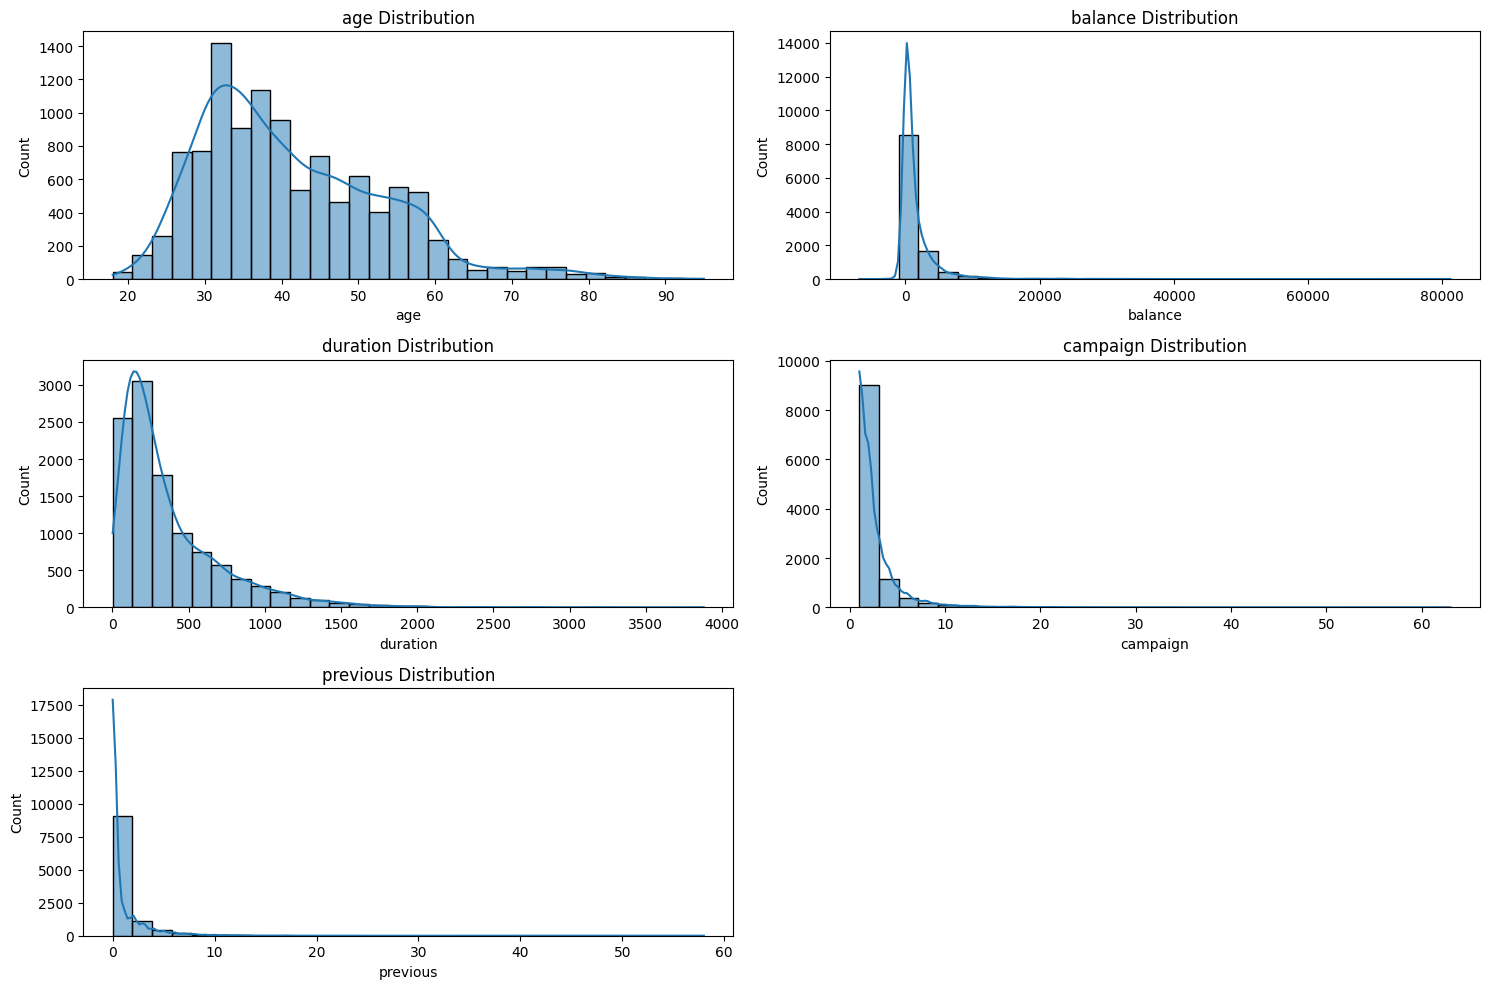

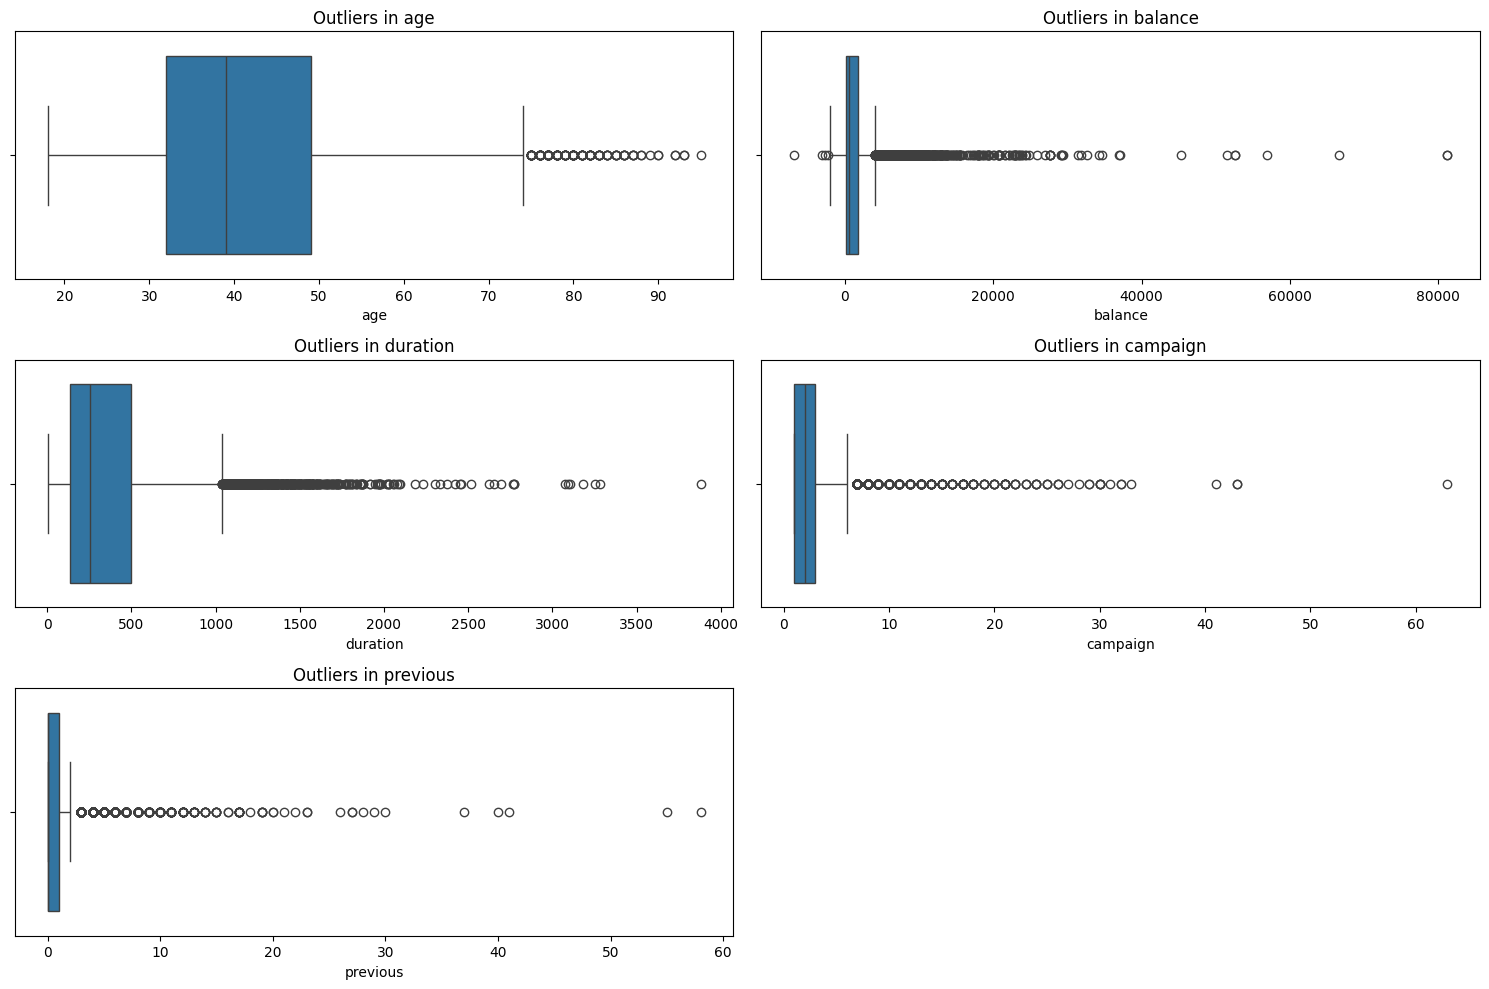

In [11]:
num_cols = ['age', 'balance', 'duration', 'campaign', 'previous']

plt.figure(figsize=(15, 10))

for i, col in enumerate(num_cols):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=model_dataset, x=col, kde=True, bins=30)
    plt.title(f'{col} Distribution')

plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 2, i+1)
    sns.boxplot(data=model_dataset, x=col)
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

In all previous plots we can observe that no variable follows a normal distribution
In the case of the age, we can see that most of the individuals are between 30 and 50 years. We can see that outliers appear from age 75 onwards. But since the data is correct, we will not take any action based on it.

Regarding the balance variable, we can se that this is the mos extreme variable since there is a huge tail on the right, thus distorting a lot the scale. Therefore, we should scale the numerical variables in methods such as KNN. If we do not perform this action, the feature balance will dominate the performance of a model.

If we analyse the duration outliers, we can see that most of the calls are less than 500 seconds long. However, there are outliers where calls lasts more than 1,000 seconds.

In the case of the campaign, we can see that in one observation a person has been called more than 60 times, which is a very strange observation and, therefore, could reduce our model's performance.

Finally, in the case of the previous contacts, most of the clients have not been previously contacted.

Based on the previous anlysis, we think that the best scaler we could use is the robust scaler since is the most robuts to outliers, However, during this work we also evaluate the performance of the models using other scalers.

### Target variable mapping

Since our target variable is encoded as a string we need to conduct a brief preprocessing. Some models cannot handle strings in the target variable. Therefore, we need to transform it as follows:

- 'yes' $\to$ 1
- 'no' $\to$ 0

We can perform this transformation at this stage because the transformation does not depend on the distribution of the splits.

In [12]:
model_dataset['deposit'] = model_dataset['deposit'].map({'no': 0, 'yes': 1})

# 2. DEFINITION OF THE OUTER AND INNER EVALUATION


In order to find a good trade-off between test partition size and training data availability, we calculate the confidence interval of a simple model accuracy using the Wilson score. For this case we are trying to find the narrower interval as possible without reducing the amount of data available for trainning. To analyze the model's behaviour as the trainning size increases, we evaluate its learning curve using a Decision Tree with a restricted max_depth of 5. This constraint is essential to prevent overfitting, ensuring that the curve reflects the actual data rather than the model's capacity to memorize noise, allowing us to see how much we can increase the test set without significantly degrading the model's predictive performance.

To guide this optimization process and evaluate model's future performance and generalization capability, we use the Accuracy metric because we have a nearly balanced dataset for this classification problem.


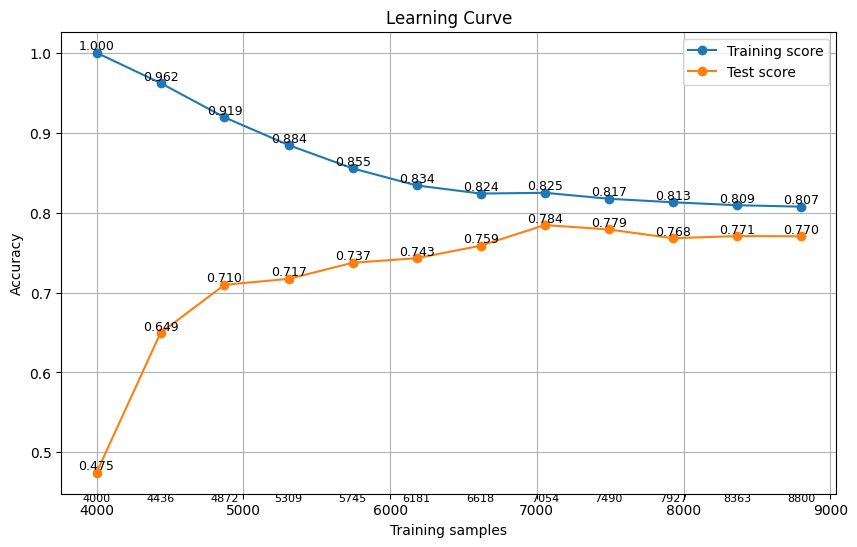

In [13]:

X = model_dataset.drop('deposit', axis=1)
y = model_dataset['deposit']

X_encoded = pd.get_dummies(X, drop_first=True) 


cv = 5
n_samples = X_encoded.shape[0]
n_max_training_samples = int(n_samples * (cv - 1) / cv)

train_sizes = np.linspace(4000, n_max_training_samples, 12, dtype=int)

train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeClassifier(max_depth=5),
    X_encoded,
    y,
    cv=cv,
    train_sizes=train_sizes,
    scoring='accuracy',
    random_state=SEED
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_mean, 'o-', label="Test score")

for x, y_ in zip(train_sizes, train_mean):
    plt.text(x, y_, f"{y_:.3f}", fontsize=9, ha='center', va='bottom')

for x, y_ in zip(train_sizes, test_mean):
    plt.text(x, y_, f"{y_:.3f}", fontsize=9, ha='center', va='bottom')

for x in train_sizes:
    plt.text(x, plt.ylim()[0],f"{x}", fontsize=8, ha='center', va='top')
plt.title("Learning Curve")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


Based on the previous plot, we observe that after reaching a train split with 7054 samples the the model's performance on the validation split is stable, that is, the green line is flat. This demosntrates that adding more samples to the trainning splits does not provide any important benefit. Therefore, we can set the training split size at 7054 samples and allocate the remaining instances to the test pasplittition. With that we maximize the statistical reliability of our accuracy scores without reducing the model's predictive power.

In [14]:
test_sz=1-round(7054/11000,2)
test_sz

0.36

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    test_size=test_sz, 
    stratify=y, 
    random_state=SEED
)

clf = DecisionTreeClassifier(random_state=SEED)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
n_test = len(y_test)

lower, upper = proportion_confint(int(acc * n_test), n_test, method='wilson')
margin_error = (upper - lower) / 2

print(f"--- Test split analysis (n={n_test}) ---")
print(f"Accuracy : {acc:.2%}")
print(f"Confidence Interval (95%): [{lower:.2%}, {upper:.2%}]")
print(f"Current margin of error: ±{margin_error:.2%}")

--- Test split analysis (n=3960) ---
Accuracy : 77.63%
Confidence Interval (95%): [76.30%, 78.90%]
Current margin of error: ±1.30%


We can see that the test interval is very narrow, therefore we can affirm that our test split size is statistically sufficient to estimate the model's performance with a high degree of confidence (margin of error < 2%).

### Outer evaluation
To estimate the model's future performance and generalization capability, we split the dataset into two distinct partitions using a Hold-out strategy. This two splits are:

- Trainning set: This set has a 64% of the dataset ans we use it for the whole model building process, which includes algorithm selection, and hyperparameter optimization.

- Test set: This split a 36% of the dataset and only serves as the Outer Evaluation. Therefore, it remains strictlty unseen during the trainning phase and we use it to get an unbiased estimation of the selected model's perfomance . We do not even use it to make decisions over the model

We employ stratified sampling to ensure the class distribution remains consistent across both partitions.


### Inner evaluation

To address the CASH problem (Combined Algorithm Selection and Hyperparameter Optimization) within the Training Set, we implement 5-Fold Cross-Validation.This inner evaluation mechanism allows us to compare different algorithm alternatives objectively, and optimize hyperparameters without touching the test set (preventing data leakage). We decide to use 5 folds instead of 10, which will be the ideal number of folds, because of the computational constrainst we have. For this work we employ the stratified version to ensure we have the same class distribution inside the folds.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(model_dataset.drop('deposit', axis=1), model_dataset['deposit'], test_size=test_sz, stratify=model_dataset['deposit'],random_state=SEED, shuffle=True)
print(X_train.shape)
print(X_test.shape)
inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
inner_scores = {}
timers_models = {}

(7040, 16)
(3960, 16)


We employ shuffle=True to create more robust and unbiased train-test and cross-validation splits, leading to a more accurate assessment of the models' performance.

# DAYS & MONTH ENCODING STRATEGY

In the EDA study, we observe that `day` and `month` features are temporal variables, which are usually very related, since January 1st and June 1st have nothing to do with each other, but if we only look at the day they would be related. However, both are represented as independent variables, thus making that the model cannot fully capture these relationships. Therefore, for this work we evaluate what is called "Cyclical Encoding" to better relate the different days.

To this end, we create the class DateToDayofYear. Since scikit-learn does not provide a direct mtehod to merge two separate variables into a single temporal one, we need to create a this new class which extendes the methods of the classes BaseEstimator, TransformerMixin, which we get from scikit-learn, more pricesily from the base module.

With this class, we are able to perfom a mapping to convert the categorical mont names into their corresponding numerical values. Inside this class we also implement a method that combines year and month to calculate the specific day of the year.

In [17]:
class DateToDayOfYear(BaseEstimator, TransformerMixin): 
    ## For this class we use chatGPT to undertsand what is X and y 
    ## The inspiration is from https://sklearn-template.readthedocs.io/en/latest/user_guide.html
    def __init__(self):

        self.month_map = {
            'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
            'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X['month_num'] = X['month'].map(self.month_map)

        def get_day_of_year(row):
            try:
                return datetime(2023, int(row['month_num']), int(row['day'])).timetuple().tm_yday ## We select 2023 because it has 365 days
            except:
                return -1

        return X.apply(get_day_of_year, axis=1).values.reshape(-1, 1)


Then we implement the cyclical_transform function to perform the mathematical operation. This function takes as an input the day of the year and maps into a 2D coordinate with the sine and cosine of the year. We employ 2 dimensions because two distinct days could have the same sine or cosine. With this we can assign a unique position on the circle to each day. To see how Ordinal Encoding would work for this case, we also implement the function identity_transform, which just returns the position that a day occupies within the year. However this function is just for hyperparameter optimization phase.

In [18]:
def cyclical_transform(X, period):
    X = np.array(X, dtype=float)
    sin_trans = np.sin(2 * np.pi * X / period)
    cos_trans = np.cos(2 * np.pi * X / period)
    return np.c_[sin_trans, cos_trans]


In [19]:
def cyclical_transform_365(X):
    return cyclical_transform(X, period=365)

def identity_transform(X):
    return np.asarray(X) ## Does nothing is to test the use of Ordinal Encoding


# CODE MODULARIZATION (Abstract Class)

In order to not implement a lot of code repeteadly for each model when using optuna, we first create a base class in order to leverage inheritance and polymorphism. The use of this abstract class allows us to define the common structure, while leaving the specific implementation details to the subclasses. In this class we include all the possible combinations to encode categorical values because we want to evaluate which encoding technique works better for each model.

In [20]:
class OptunaSearchBase:
    
    def __init__(self, model_pipeline, n_trials=50, random_state=SEED):
        self.model_pipeline = model_pipeline
        self.n_trials = n_trials
        self.random_state = random_state
        self.best_params_ = None
        self.best_score_ = None
        self.best_model_ = None
        self.study_ = None
        self.preprocessing_config = {
            'encoders': self._get_encoders()
        }
    
    def fit(self, X_train, y_train, cv=5):
        self.study_ = optuna.create_study(direction='maximize')
        self.study_.optimize(
            lambda trial: self.objective(trial, X_train, y_train),
            n_trials=self.n_trials
        )
        self.best_params_ = self.study_.best_params
        self.best_score_ = self.study_.best_value
        return self
    
    def get_pipeline(self):
        return self.best_model_
    
    ## Here we use ChatGPT to help with the display of the pipeline in an html format

    def __repr__(self):
        if self.best_model_ is None:
            return f"OptunaSearch (not fitted, n_trials={self.n_trials})"
        return repr(self.best_model_)

    def _repr_html_(self):
        if self.best_model_ is None:
            return "<b>OptunaSearch</b> (not fitted)"
        html = estimator_html_repr(self.best_model_)
        return f"<h3>OptunaSearch (best_model_)</h3>{html}"
    def _get_encoders(self):
        return {
            'education': {
                'ohe': OneHotEncoder(handle_unknown='ignore', sparse_output=False),
                'ord': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            },
            'job': {
                'ohe': OneHotEncoder(handle_unknown='ignore', sparse_output=False),
                'ord': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            },
            'marital': {
                'ohe': OneHotEncoder(handle_unknown='ignore', sparse_output=False),
                'ord': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            },
            'dates': {
                'identity': identity_transform,
                'cyclical': cyclical_transform_365,
            }
        }
    

    
    def objective(self, trial, X_train, y_train):

        date_key = trial.suggest_categorical(
            "preprocessor__dates__encode__func",
            list(self.preprocessing_config['encoders']['dates'].keys())
        )
        edu_key = trial.suggest_categorical(
            "preprocessor__education__encode",
            list(self.preprocessing_config['encoders']['education'].keys())
        )
        job_key = trial.suggest_categorical(
            "preprocessor__job__encode",
            list(self.preprocessing_config['encoders']['job'].keys())
        )
        marital_key = trial.suggest_categorical(
            "preprocessor__marital__encode",
            list(self.preprocessing_config['encoders']['marital'].keys())
        )
        self.model = clone(self.model_pipeline)
        self.model.set_params(
            preprocessor__dates__encode__func = self.preprocessing_config['encoders']['dates'][date_key],
            preprocessor__education__encode   = self.preprocessing_config['encoders']['education'][edu_key],
            preprocessor__job__encode         = self.preprocessing_config['encoders']['job'][job_key],
            preprocessor__marital__encode     = self.preprocessing_config['encoders']['marital'][marital_key]
        )
        
    def fit(self, X, y):
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
        study.optimize(lambda trial: self.objective(trial, X, y), n_trials=self.n_trials)
        self.best_params_ = self.decode_params(study.best_params)
        self.best_score_ = study.best_value
        self.best_model_ = clone(self.model_pipeline)
        self.best_model_.set_params(**self.best_params_)
        self.best_model_.fit(X, y)
        return self

    

    def decode_params(self, params):
        decoded_params = params.copy()
        decoded_params['preprocessor__dates__encode__func'] = self.preprocessing_config['encoders']['dates'][params['preprocessor__dates__encode__func']]
        decoded_params['preprocessor__education__encode'] = self.preprocessing_config['encoders']['education'][params['preprocessor__education__encode']]
        decoded_params['preprocessor__job__encode'] = self.preprocessing_config['encoders']['job'][params['preprocessor__job__encode']]
        decoded_params['preprocessor__marital__encode'] = self.preprocessing_config['encoders']['marital'][params['preprocessor__marital__encode']]
        return decoded_params


# 3. BASIC METHODS: KNN AND TREES


In this section, we initiate the modeling phase by exploring two fundamental supervised learning algorithms which are the k-Nearest Neighbors (KNN) and Decision Trees. To properly evaluate the different methods, we first run the algorithms with their default hyperparameters and compare them against a dummy classifier. This allows us to understand if the models are actually learning something useful or just guessing. We then evaluate the models' performance after doing hyperparameter optimization.

For the dummy model, we employ the 'most_frequent' strategy that gets the sample mode (the most frequent class) to predict.

In [21]:
dummy_class=DummyClassifier(strategy='most_frequent')
dummy_scores = cross_val_score(dummy_class, X_train, y_train, cv=inner, scoring='accuracy')
inner_scores['dummy'] = dummy_scores.mean()
print("Dummy Accuracy Results:")
print(inner_scores['dummy'])

Dummy Accuracy Results:
0.5254261363636363


## KNN

KNN is a instance-based learning algorithm since it simply stores the training data and performs all the computations during the predictions, in what is called lazy learning. The hyperparameters of the algorithm are:

- Number of neighbours (`K`): This hyperparameter indicates the number of neighbors that the algorithm takes into account for the majority voting process. A small K makes the model very sensitive to the noise, while a large K makes the decision boundaries more smooth. However if we would include as neighbours as instances, the algorithm would classify all the new images as the majority class. In Scikit-learn, the default value for this hyperparameter is 5.

- `Weights`: The hyperparameter  determines the influence of each neighbour during the votating process. There are two main strategies, which are:
  - Uniform: All the neighbors contribute equally to the vote. This is teh default strategy in Scikit-learn.
  - Distance: Closer neighbors have a greater influence on the vote.
- `p`: The hyperparameter defines the distance metric that the algorithm uses to compute the distance between instances. The scikit-learn implementation employs the Minkowski metric, which is a generalization of the Euclidean and Manhattan distances. The value of `p` determines which specific distance metric is used. If p = 1, the algorithm uses the Manhattan distance. If p = 2, it uses the Euclidean distance, which is the default value in Scikit-learn. 

### Preprocessing

The KNN algorithm needs the data to be in a specific format to work properly. Therefore, we need to preprocess the data to be able to use KNN.

KNN cannot process text strings. Therefore, we need to transform all categorical variables into numbers. To this end, we employ different types of encoding. For the day and month we employ the cyclical encoding to better relate the different days. For the job we could try Ordinal Encoding, but as it has only 12 different values, for the default parameters we use the One-Hot encoding to change the information since jobs do not depend each other.

For education, we employ Ordinal Encoding because there is a clear hierarchy (Primary < Secondary < Tertiary). Preserving this order we believe that allows the KNN to interpret the distance between education levels meaningfully.

Finally, for the remaining low-cardinality nominal variables (marital, contact, poutcome) and binary variables (default, housing, loan), we also use the One-Hot Encoding.

However, the choice of encoding is not trivial and can significantly impact the model. Therefore, we will treat the encoding strategy as a hyperparameter during the hyperparameter optimizatio to empirically determine which representation provides the best accuracy for the KNN algorithm.

During the [Simplified Eda](#simple-eda) stage we identify some missing values in the martial and education variables. Therefore, we leverage the SimpleImputer scikit-learn class and, as we do no thave a lot of null values, we fill these values with the mode in the case of the marital features because it won't distort very much the distribution of the marital variable. In the case of education, we fill missing values with the class 'unknown since we already have a class with this value. For the rest of variables, we also us the SimpleImputer just in case there are any missing values in the future. For the numerical variables, we use the median to fill missing values because it is more robust to outliers.

In the [Eda](#simple-eda) stage we also observe that some variables have a much larger scale and variance than others. The prevent one variable to dominate over others, we scale the numerical variables. Form all the studied techniques, we  first use robust sacling because outliers have less influence on this than the rest.

In the next lines we define how we proceed to create the needed pipelines:


1st we create different arrays with all the features we are using to apply different strategies:


In [ ]:
num_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

onehot_features = ['job', 'default', 'housing', 'loan', 'contact', 'poutcome']

marital_features = ['marital']

date_cols = ['day', 'month']

education_features = ['education']
education_order = [['unknown', 'primary', 'secondary', 'tertiary']] # To define the explicit order


And then we create all the needed pipelines with the use of ColumnTranformer. With this we ensure that the differnt type of features undergo their specific tranformation in isolation, thus preventing the data lekeage.

We also use the remainder='drop' as a safety mechanism that automatically discards any unused column from the feature set. With all this, we get an end-to-end pipeline that perfectly formats the needed data for the KNN.

In [72]:

date_pipeline = Pipeline([
    ('day_of_year', DateToDayOfYear()),
    ('encode', FunctionTransformer(cyclical_transform_365, validate=False))
])

marital_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), num_features),

        ('onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), onehot_features),

        ('education', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('encode', OrdinalEncoder(categories=education_order, handle_unknown='use_encoded_value', unknown_value=-1))
        ]), education_features),

        ('dates', date_pipeline, date_cols) ,

        ('marital', marital_pipeline, marital_features)
    ],
    remainder='drop' ## This is to ensure we only use the defined columns and not deposit for example.
)


knn_pipeline_default = Pipeline(steps=[
    ('preprocessor', preprocessor_knn),
    ('classifier', KNeighborsClassifier())
])

knn_pipeline_default

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Global KNN function definition

We now create a function to modularize the training and evaluation of the KNN algorithm. This function can be used either to train KNN with the default parameters or during the hyperparameter optimization phase.  To reuse the code, we extend the OptunaSearchBase class we created in the previous section.

In [ ]:
class OptunaSearch_KNN(OptunaSearchBase):
    def __init__(self, knn_pipeline, n_trials=50):
        super().__init__(knn_pipeline, n_trials)
        
        self.preprocessing_config['num_scalers'] = {
            'robust': RobustScaler(),
            'standard': StandardScaler(),
            'minmax': MinMaxScaler(),
        }

    def objective(self,trial, X_train, y_train):

        super().objective(trial, X_train, y_train)
        scaler_key = trial.suggest_categorical(
            "preprocessor__num__scaler",
            list(self.preprocessing_config['num_scalers'].keys())
        )

        n_neighbors = trial.suggest_int("knn__n_neighbors", 3, 15, step=2)
        weights = trial.suggest_categorical("knn__weights", ["uniform", "distance"])
        p = trial.suggest_int("knn__p", 1, 9, step=1)

        self.model.set_params(
            preprocessor__num__scaler         = self.preprocessing_config['num_scalers'][scaler_key],
            knn__n_neighbors                  = n_neighbors,
            knn__weights                      = weights,
            knn__p                            = p
        )

        scores = cross_val_score(self.model, X_train, y_train, cv=inner, scoring='accuracy', n_jobs=-1)
        return scores.mean()

    def decode_params(self, params):
        params=super().decode_params(params)
        params['preprocessor__num__scaler'] = self.preprocessing_config['num_scalers'][params['preprocessor__num__scaler']]
        print(params)
        return params

In [ ]:
def HPO_method_Factory(method,knn_pipeline,hyperparams,cv,inner_scores_name,trials=30):
    if method == 'grid_search':
        return GridSearchCV(knn_pipeline, hyperparams, cv=cv, scoring='accuracy', n_jobs=-1,verbose=1), inner_scores_name+'_grid_search'
    elif method == 'random_search':
        return RandomizedSearchCV(knn_pipeline, hyperparams, cv=cv, scoring='accuracy', n_jobs=-1,verbose=1, random_state=SEED), inner_scores_name+'_random_search'
    elif method == 'optuna_search':
        return OptunaSearch_KNN(knn_pipeline, n_trials=trials), inner_scores_name+'_optuna_search'
    else:
        return GridSearchCV(knn_pipeline, hyperparams, cv=cv, scoring='accuracy', n_jobs=-1,verbose=1), inner_scores_name+'_default'
    
        

In [ ]:
def train_and_evaluate_knn(X_train, y_train,knn_pipeline,hyperparameters,inner_scores_name, method='default',trials=30):
  Knn,inner_scores_name = HPO_method_Factory(method,knn_pipeline,hyperparameters, inner,inner_scores_name,trials=trials)
  time_start = time.time()
  Knn.fit(X_train, y_train)
  time_end = time.time()
  inner_scores[inner_scores_name] = Knn.best_score_
  timers_models[inner_scores_name] = time_end - time_start
  return Knn

### Default KNN computation

In [26]:
train_and_evaluate_knn(X_train=X_train, y_train=y_train,knn_pipeline=knn_pipeline_default,hyperparameters={},inner_scores_name='knn')
print("Default KNN Results:")
print(inner_scores['knn_default'])
print("Training time:")
print(f"{timers_models['knn_default']} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Default KNN Results:
0.7345170454545454
Training time:
16.747966051101685 seconds


### KNN HPO

After this, we are interested on finding which are the best hypeparameters for KNN. In this work we ars interested on tuning not only the model's internal hyperparameters but also the preprocessing steps. Threfore, we treat feature engineering decisions as search parameters inside the pipeline. To find the best trade-off between computer efficiency and optimal configuration, we compare three distinct optimization strategies, which are Grid Search, Random Search, and Optuna.

In [ ]:
num_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

onehot_features = ['default', 'housing', 'loan', 'contact', 'poutcome']

marital_features = ['marital']
job_features = ['job'] ## Now we evaluate one-hot vs Ordinal Encoding for job variable

date_cols = ['day', 'month']

education_features = ['education']
education_order = [['unknown', 'primary', 'secondary', 'tertiary']] # To define the explicit order

In [71]:

date_pipeline = Pipeline([
    ('day_of_year', DateToDayOfYear()),
    ('encode', FunctionTransformer(cyclical_transform_365, validate=False))
])

marital_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), num_features),

        ('onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), onehot_features),

        ('education', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('encode', OrdinalEncoder(categories=education_order, handle_unknown='use_encoded_value', unknown_value=-1))
        ]), education_features),

        ('job', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), job_features),
        ('dates', date_pipeline, date_cols) ,

        ('marital', marital_pipeline, marital_features)
    ],
    remainder='drop' ## This is to ensure we only use the defined columns and not deposit for example.
)


knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_knn),
    ('knn', KNeighborsClassifier())
])

knn_pipeline

,steps,"[('preprocessor', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
hyperparams_knn_pre = {
    'preprocessor__dates__encode__func': [
        identity_transform,
        cyclical_transform_365
    ],
    'preprocessor__education__encode': [
        OneHotEncoder(handle_unknown='ignore', sparse_output=False),
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    ],
    'preprocessor__job__encode': [
        OneHotEncoder(handle_unknown='ignore', sparse_output=False),
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    ],
    'preprocessor__num__scaler': [
        RobustScaler(),
        StandardScaler(),
        MinMaxScaler()
    ],
    'preprocessor__marital__encode': [
        OneHotEncoder(handle_unknown='ignore', sparse_output=False),
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    ],
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2, 4, 6, 8],
}


#### Grid search

In [30]:
grid_knn = train_and_evaluate_knn(
    X_train=X_train,
    y_train=y_train,
    knn_pipeline=knn_pipeline,
    hyperparameters=hyperparams_knn_pre,
    inner_scores_name='knn_hpo',
    method='grid_search'
)


Fitting 5 folds for each of 3360 candidates, totalling 16800 fits


In [31]:
print("Grid Search KNN Results:")
print("Best params:", grid_knn.best_params_)
print(inner_scores['knn_hpo_grid_search'])
print("Training time:")
print(f"{timers_models['knn_hpo_grid_search']} seconds")
grid_knn

Grid Search KNN Results:
Best params: {'knn__n_neighbors': 7, 'knn__p': 6, 'knn__weights': 'distance', 'preprocessor__dates__encode__func': <function identity_transform at 0x0000025AF44D7F60>, 'preprocessor__education__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__num__scaler': StandardScaler()}
0.823153409090909
Training time:
7386.614884376526 seconds


,estimator,Pipeline(step...lassifier())])
,param_grid,"{'knn__n_neighbors': [3, 5, ...], 'knn__p': [1, 2, ...], 'knn__weights': ['uniform', 'distance'], 'preprocessor__dates__encode__func': [<function ide...0025AF44D7F60>, <function cyc...0025AF44D7CE0>], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('onehot', ...), ...]"


#### Random search

In [32]:
random_knn = train_and_evaluate_knn(
    X_train=X_train,
    y_train=y_train,
    knn_pipeline=knn_pipeline,
    hyperparameters=hyperparams_knn_pre,
    inner_scores_name='knn_hpo',
    method='random_search'
)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [33]:
print("Random Search KNN Results:")
print("Best params:", random_knn.best_params_)
print(inner_scores['knn_hpo_random_search'])
print("Training time:")
print(f"{timers_models['knn_hpo_random_search']} seconds")
random_knn

Random Search KNN Results:
Best params: {'preprocessor__num__scaler': StandardScaler(), 'preprocessor__marital__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__education__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__dates__encode__func': <function identity_transform at 0x0000025AF44D7F60>, 'knn__weights': 'uniform', 'knn__p': 6, 'knn__n_neighbors': 5}
0.822159090909091
Training time:
26.13945722579956 seconds


,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'knn__n_neighbors': [3, 5, ...], 'knn__p': [1, 2, ...], 'knn__weights': ['uniform', 'distance'], 'preprocessor__dates__encode__func': [<function ide...0025AF44D7F60>, <function cyc...0025AF44D7CE0>], ...}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,100563523
,error_score,nan


In [35]:
optuna_knn = train_and_evaluate_knn(
    X_train=X_train,
    y_train=y_train,
    knn_pipeline=knn_pipeline,
    hyperparameters=hyperparams_knn_pre,
    inner_scores_name='knn_hpo',
    method='optuna_search',
    trials=50
)

[I 2025-12-09 16:05:34,642] A new study created in memory with name: no-name-c5ba1744-ae75-4fdd-96bf-1a1627a53dfc
[I 2025-12-09 16:05:42,757] Trial 0 finished with value: 0.7970170454545454 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__num__scaler': 'robust', 'knn__n_neighbors': 11, 'knn__weights': 'distance', 'knn__p': 4}. Best is trial 0 with value: 0.7970170454545454.
[I 2025-12-09 16:05:49,903] Trial 1 finished with value: 0.8082386363636364 and parameters: {'preprocessor__dates__encode__func': 'identity', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ord', 'preprocessor__num__scaler': 'robust', 'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'knn__p': 4}. Best is trial 1 with value: 0.8082386363636364.
[I 2025-12-09 16:05:50,236] Trial 2 finished with value: 0.776

{'preprocessor__dates__encode__func': <function identity_transform at 0x000001E2BF608540>, 'preprocessor__education__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__num__scaler': StandardScaler(), 'knn__n_neighbors': 9, 'knn__weights': 'uniform', 'knn__p': 3}


In [38]:
print("Optuna Search KNN Results:")
print("Best params:", optuna_knn.best_params_)
print(inner_scores['knn_hpo_optuna_search'] )
print("Training time:")
print(f"{timers_models['knn_hpo_optuna_search']} seconds")
optuna_knn 


Optuna Search KNN Results:
Best params: {'preprocessor__dates__encode__func': <function identity_transform at 0x000001E2BF608540>, 'preprocessor__education__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__num__scaler': StandardScaler(), 'knn__n_neighbors': 9, 'knn__weights': 'uniform', 'knn__p': 3}
0.8183238636363637
Training time:
234.6778678894043 seconds


,steps,"[('preprocessor', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Conclusions

In [7]:
df = pd.DataFrame({
    "Model": inner_scores.keys(),
    "Inner Score": inner_scores.values(),
    "Time (s)": [timers_models.get(m, None) for m in inner_scores.keys()]
})

df = df.sort_values("Inner Score", ascending=False)

print(df)

                   Model  Inner Score     Time (s)
2    knn_hpo_grid_search     0.823153  7386.614884
3  knn_hpo_random_search     0.822159    26.139457
4  knn_hpo_optuna_search     0.818324   234.677868
1            knn_default     0.734517     3.191827
0                  dummy     0.525426          NaN


After evaluating three hyperparameter optimization strategies, we can see that all of them improve the pefromance of the model with the default parameters, thus getting, at least more than 8% of accuracy improvement. However, we should take inot account not only the enhancement but also the computational complexity. We can see that, while the default model requires only around 3 seconds to run, the optimization strategies demand considerably more resources.

In the comparison, we observe that the Grid Search is the most expensive method, taking over 2 hours (7.386s) to complete its exhaustive search. In contrast, the Random Search is the most efficient method, achieving nearly the same accuracy (82.21% vs 82.31%) in just 26 seconds. Optuna is a middle (~4 minutes), thus providing a trade-off between structured exploration with execution time.



#### Analysis of Hyperparameters

To correctly explain how the performance of the KNN models depend on the hyperparameters, we select the Optuna Search because it is allows us to understand the relationship between the hyperparameters of KNN and the accuracy.

We can observe that the type of scaling used for the numerical variables, highly influences the performance of KNN. We observe that the worst results matches with the use of MinMax scaling, which es probably due to the large amount of outliers that are present in this dataset for the numerical variables. In the case of the RobustScaler, we see that the model gets a high accuracy (around 0.80), but slightly lower than that obtained when we use the standard scaling, especially with a high number of neighbours. This means that for this case is better to center the mean around 0 and the standard eviation around 1.

Then, we can see that the number of neighbours are also important for the scalability. In the trials we can see that using betwwen 9 and 13 neighbours allows the model to better distinct the data insights since the model gets the highest accuracy. As expected, low k values consistently result in poor performance because a low k makes the model to be too sensitive to noise. 

However, although increasing neighbors generally stabilizes predictions, using an excessively high number of ks could lead to oversmoothing, where local patterns are lost and the model becomes biased towards the majority class of the entire dataset (underfitting). Therefore, the range of 9-15 represents the optimal balance between sensitivity to local structure and robustness against noise.

We can also observe that the encoding strategy plays a significant role. The top-performing models usually employ OneHotEncoder to encode the job variable, while using Ordinal Encoding for education and marital encoding. We can see that Optuna leverages the hierarchy of the studies. The marital has no intrinsic order, but Optuna assigns one to it and thereby obtains the best results.

In contrast, Optuna keeps OneHotEncoder for the job variable. Since professions have no intrinsic numerical order, using Ordinal Encoding here would have introduced false relationships, which would distort the neighbor selection. Therefore, we can see that Optuna reduces reduces dimensionality where it finds an order, while preventing bias where it does not.

It seems that the ordinal encoding is introducing some artificial order relationships between nominal categories, thus disorting the distance calculations and, therefore, degrading accuracy because KNN relies on the minkowski distance.

Finally, contrary to the intuition that closer neighbors should count more, the best configuration was achieved using 'uniform' weighting combined with a Minkowski parameter of p=3. This suggests that giving the same influence to all neighbors and penalizing larger feature differences more strongly than the standard Euclidean distance helps the model better capture relationships in the data.

If we compare the Optuna hyperparameters with the Grid ones, we can see that while both strategies choose StandardScaler for numerical variables, they do not agree in how they interpret the neighborhood structure. Grid Search identifies a more complex configuration that gets a slightly better result. While Optuna gets its the best performance using k=9 with uniform weights and a Minkowski parameter of p=3, we observe that the Grid Search finds an optimal combination using k=7, 'distance' weights, and a higher Minkowski parameter of p=6.

The fact that Grid Search selects 'distance' weights contradicts the findings from the Optuna trial, suggesting that for the absolute best performance, closer neighbors should have a higher influence on the classification. Regarding the encoding strategy, Grid Search finds best the use of OneHotEncoder for the education variable, whereas Optuna suggests Ordinal. This suggests that treating education as purely nominal categories helps the model distinguish better between educational backgrounds in this specific problem.


## Trees

Decision trees are model-based algorithms that learn a set of hierarchical if–then rules by recursively splitting the feature space. 
Unlike KNN, trees do not rely on a distance metric but on univariate threshold splits over individual features. 

The default Scikit-Learn hyperparameters for DecisionTreeClassifier are:

- criterion = "gini"
- splitter = "best"
- max_depth = None
- min_samples_split = 2
- min_samples_leaf = 1
- min_weight_fraction_leaf = 0.0
- max_features = None
- random_state = None
- max_leaf_nodes = None
- min_impurity_decrease = 0.0
- class_weight = None

Obviously, with regular computers, it is unviable to compute and compare all the different combinations of all the possible values of all the different hyperparameters. 

### Selected Hyperparameters for Tuning

We adopt a strategy of elimination: we fix or discard parameters that are either redundant, not applicable to our specific case (single tree, balanced data), or less effective than others for regularization.

**1. Parameters Fixed (Not Tuned):**

* `splitter`: Fixed to "best".
    * The "random" option is designed for Ensemble methods (like Random Forests) to induce diversity among trees. For a single Decision Tree, we always want the mathematically optimal split at each node.
* `max_features`: Fixed to None (consider all features).
    * Similar to `splitter`, restricting the number of features is a technique for Ensembles. A single tree should have access to all available information to make the best decisions.
* `max_leaf_nodes`: Fixed to None.
    * It competes with `max_depth` to control tree size. `max_depth` is more intuitive to interpret and visualize.
* `min_impurity_decrease` & `min_weight_fraction_leaf`: Fixed to 0.0.
    * These provide very fine-grained control that is often hard to tune intuitively. We rely on depth and leaf size for regularization.
* `class_weight`: Fixed to None.
    * As established in the EDA, our dataset does not suffer from severe imbalance, so weighting classes is unnecessary.
* `random_state`: Fixed to SEED.
    * To ensure reproducibility.

**2. Parameters Selected for Tuning (The Grid):**

After the elimination process, we are left with the four most critical hyperparameters that control the bias-variance tradeoff:

* `criterion`: (gini vs entropy) 
    * To check if the impurity measure affects performance.
* `max_depth`
    * To control the global complexity of the model and prevent memorization (Overfitting). 
* `min_samples_split`
    * Determines the minimum number of samples required to attempt a split. Higher values prevent the model from learning specific details of small groups.
* `min_samples_leaf`
    * Determines the minimum number of samples required to be a leaf node. This ensures that a prediction is based on a statistically significant group.

<a id="trees_preprocessing"></a>

### Preprocessing

Preprocessing for tree-based models differs significantly from KNN. Since Decision Trees rely on threshold splits regarding individual features rather than distance metrics, feature scaling is unnecessary. Variables with large numerical ranges, such as balance, do not dominate the model, so we can skip scaling to preserve the interpretability of the original values.

Regarding categorical variables, although theoretical decision trees can handle them directly, Scikit-Learn's implementation requires numerical input. Therefore, we must apply encoding. We define a specific preprocessor for trees that handles this encoding and missing value imputation without normalizing the data.

For missing values, we initially apply standard imputation strategies (most frequent for categorical and median for numerical) to ensure the model receives complete data. Later, during the optimization phase, we will test an alternative approach: treating missing values as a distinct category (e.g., unknown). This allows us to investigate if the absence of information itself carries predictive power for the classification.

#### Why a separate preprocessor for Trees?

Although we could reuse the KNN preprocessor, we define a specific **preprocessor_tree** without the scaling step (StandardScaler or RobustScaler) for two main reasons:

1. Interpretability Decision Trees partition the feature space using orthogonal cuts. By keeping the original scale of numerical features (e.g., `age` in years, `duration` in seconds), the resulting tree splits are human-readable (e.g., `age <= 30` is clearer than `age <= -0.54`). This is crucial for the interpretation and Shallow Tree analysis required later.

2. Theoretical Properties: Unlike distance-based algorithms (KNN), Decision Trees are invariant to monotonic transformations and scaling. Adding a scaler introduces unnecessary computational steps without improving model performance.

Therefore, **preprocessor_tree** will handle missing values and categorical encoding (required by Scikit-Learn's implementation) but will preserve the magnitude of numerical features.

In [ ]:
num_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
onehot_features = ['default', 'housing', 'loan', 'contact', 'poutcome']
marital_features = ['marital']
job_features = ['job']
date_cols = ['day', 'month']
education_features = ['education']
education_order = [['unknown', 'primary', 'secondary', 'tertiary']]

date_pipeline = Pipeline([
    ('day_of_year', DateToDayOfYear()),
    ('encode', FunctionTransformer(cyclical_transform_365, validate=False))
])

marital_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_tree = ColumnTransformer(
    transformers=[

        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ]), num_features),

        ('onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), onehot_features),

        ('education', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('encode', OrdinalEncoder(categories=education_order, handle_unknown='use_encoded_value', unknown_value=-1))
        ]), education_features),

        ('job', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), job_features),
        
        ('dates', date_pipeline, date_cols),

        ('marital', marital_pipeline, marital_features)
    ],
    remainder='drop'
)


tree_pipe_default = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(random_state=SEED))
])

tree_pipe_default

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Global Trees function definition

We now create a function to modularize the training and evaluation of the Trees algorithm. This function can be used either to train Trees with the default parameters or during the hyperparameter optimization phase. To reuse the code, we extend the OptunaSearchBase class we created in the previous section.

In [ ]:
class OptunaSearch_Tree(OptunaSearchBase):
    def __init__(self, tree_pipeline, n_trials=50):
        super().__init__(tree_pipeline, n_trials)
        self.preprocessing_config['imputers'] = {
            'most_frequent': SimpleImputer(strategy='most_frequent'),
            'constant': SimpleImputer(strategy='constant', fill_value='unknown'),
        }
    

    def objective(self,trial, X_train, y_train):

        super().objective(trial, X_train, y_train)
        education_imputer_key = trial.suggest_categorical(
            "preprocessor__education__imputer",
            list(self.preprocessing_config['imputers'].keys())
        )
        job_imputer_key = trial.suggest_categorical(
            "preprocessor__job__imputer",
            list(self.preprocessing_config['imputers'].keys())
        )
        marital_imputer_key = trial.suggest_categorical(
            "preprocessor__marital__imputer",
            list(self.preprocessing_config['imputers'].keys())
        )
        onehot_imputer_key = trial.suggest_categorical(
            "preprocessor__onehot__imputer",
            list(self.preprocessing_config['imputers'].keys())
        )

        max_depth = trial.suggest_int("classifier__max_depth", 2, 40)
        min_samples_split = trial.suggest_int("classifier__min_samples_split", 2, 100)
        min_samples_leaf = trial.suggest_int("classifier__min_samples_leaf", 1, 20)
        criterion = trial.suggest_categorical("classifier__criterion", ["gini", "entropy"])


        self.model.set_params(
            preprocessor__education__imputer = self.preprocessing_config['imputers'][education_imputer_key],
            preprocessor__job__imputer       = self.preprocessing_config['imputers'][job_imputer_key],
            preprocessor__marital__imputer   = self.preprocessing_config['imputers'][marital_imputer_key],
            preprocessor__onehot__imputer   = self.preprocessing_config['imputers'][onehot_imputer_key],
            classifier__max_depth         = max_depth,
            classifier__min_samples_split = min_samples_split,
            classifier__min_samples_leaf  = min_samples_leaf,
            classifier__criterion         = criterion
        )

        scores = cross_val_score(self.model, X_train, y_train, cv=inner, scoring='accuracy', n_jobs=-1)
        return scores.mean()
    
    
    def decode_params(self, params):
        params=super().decode_params(params)
        params['preprocessor__education__imputer'] = self.preprocessing_config['imputers'][params['preprocessor__education__imputer']]
        params['preprocessor__job__imputer'] = self.preprocessing_config['imputers'][params['preprocessor__job__imputer']]
        params['preprocessor__marital__imputer'] = self.preprocessing_config['imputers'][params['preprocessor__marital__imputer']]
        params['preprocessor__onehot__imputer'] = self.preprocessing_config['imputers'][params['preprocessor__onehot__imputer']]
        return params

In [ ]:
def HPO_method_Factory_Tree(method, tree_pipeline, hyperparams, cv, inner_scores_name, trials=100):

    N_JOBS = -1
    
    if method == 'grid_search':
        return GridSearchCV(tree_pipeline, hyperparams, cv=cv, scoring='accuracy', n_jobs=N_JOBS, verbose=1), inner_scores_name+'_grid_search'
    
    elif method == 'random_search':
        return RandomizedSearchCV(tree_pipeline, hyperparams, cv=cv, scoring='accuracy', n_jobs=N_JOBS, verbose=1, random_state=SEED), inner_scores_name+'_random_search'
    
    elif method == 'optuna_search':
        return OptunaSearch_Tree(tree_pipeline, n_trials=trials), inner_scores_name+'_optuna_search'
    
    else:
        return GridSearchCV(tree_pipeline, hyperparams, cv=cv, scoring='accuracy', n_jobs=N_JOBS, verbose=1), inner_scores_name+'_default'

In [ ]:
def train_and_evaluate_tree(X_train, y_train, tree_pipeline, hyperparameters, inner_scores_name, method='default', trials=100):

    
    Tree_model, final_name = HPO_method_Factory_Tree(
        method, 
        tree_pipeline, 
        hyperparameters, 
        inner, 
        inner_scores_name, 
        trials=trials
    )
    start_time = time.time()

    Tree_model.fit(X_train, y_train)
    end_time = time.time()
    
    inner_scores[final_name] = Tree_model.best_score_
    timers_models[final_name] = end_time - start_time
    
    return Tree_model

### Default Tree computation

In [36]:
train_and_evaluate_tree(X_train=X_train, y_train=y_train,tree_pipeline=tree_pipe_default,hyperparameters={},inner_scores_name='tree')
inner_scores

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'knn_default': np.float64(0.7345170454545454),
 'tree_default': np.float64(0.7896306818181819)}

### Interpretability: Shallow Trees

A Shallow Tree is a decision tree whose maximum depth is small and controlled (for example, to 2 or 3 levels). Shallow Trees belong to a family of algorithms called "Shallow Learning".

 By restricting how many splits the model can make, we obtain a much simpler structure that is easy to visualize and explain, even to non-technical stakeholders. The trade-off is that such a model may be too simple to capture more complex patterns in the data.

In practice, shallow trees are useful as an exploratory tool. They help us understand which features are most important (those appearing near the root) and reveal simple decision rules that drive the predictions. This makes them a natural starting point before fitting more complex or deeper models, and a valuable aid for feature engineering and model interpretability.

Unlike our hyperparameter optimization phase, we do not employ the `OptunaSearch_Tree` class here, as this step prioritizes controlled interpretability over automated search for optimal performance.



In [31]:
tree_pipe_shallow = Pipeline(steps=[
    ('preprocessor', preprocessor_tree), 
    ('classifier', DecisionTreeClassifier(max_depth=3, random_state=SEED)) #max_depth=3 for a shallow tree
])

tree_pipe_shallow.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Extracting transformed feature names

Because our preprocessing pipeline includes several nested transformers (imputers, encoders and a custom date transformer), the raw decision tree only “sees” the transformed feature matrix, not the original column names. To recover meaningful feature names for visualization and feature importance analysis, we iterate over the `ColumnTransformer` and, whenever possible, call `get_feature_names_out` on the final step of each transformer. For custom components that do not implement this method (e.g. the date transformation), we manually assign an informative name (such as `"day_of_year"`). This yields a consistent list of transformed feature names aligned with the tree’s input features.


In [43]:
pre = tree_pipe_shallow.named_steps["preprocessor"]

feature_names_transformed = []

for name, transformer, cols in pre.transformers_:
    if name == "remainder":
        continue

    # CASE A: transformer is a Pipeline
    if hasattr(transformer, "steps"):
        found = False
        for step_name, step_est in reversed(transformer.steps):
            if hasattr(step_est, "get_feature_names_out"):
                fn = step_est.get_feature_names_out(cols)
                feature_names_transformed.extend(fn)
                found = True
                break

        if not found:
            if name == "dates":
                #Two variables needed for date column (sin and cos)
                for c in cols:
                    feature_names_transformed.append(f"{c}_sin")
                    feature_names_transformed.append(f"{c}_cos")
            else:
                feature_names_transformed.extend(cols)

    # CASE B: transformer has get_feature_names_out directly
    elif hasattr(transformer, "get_feature_names_out"):
        fn = transformer.get_feature_names_out(cols)
        feature_names_transformed.extend(fn)

    # CASE C: fully custom transformer without names
    else:
        if name == "dates":
            for c in cols:
                feature_names_transformed.append(f"{c}_sin")
                feature_names_transformed.append(f"{c}_cos")
        else:
            feature_names_transformed.extend(cols)



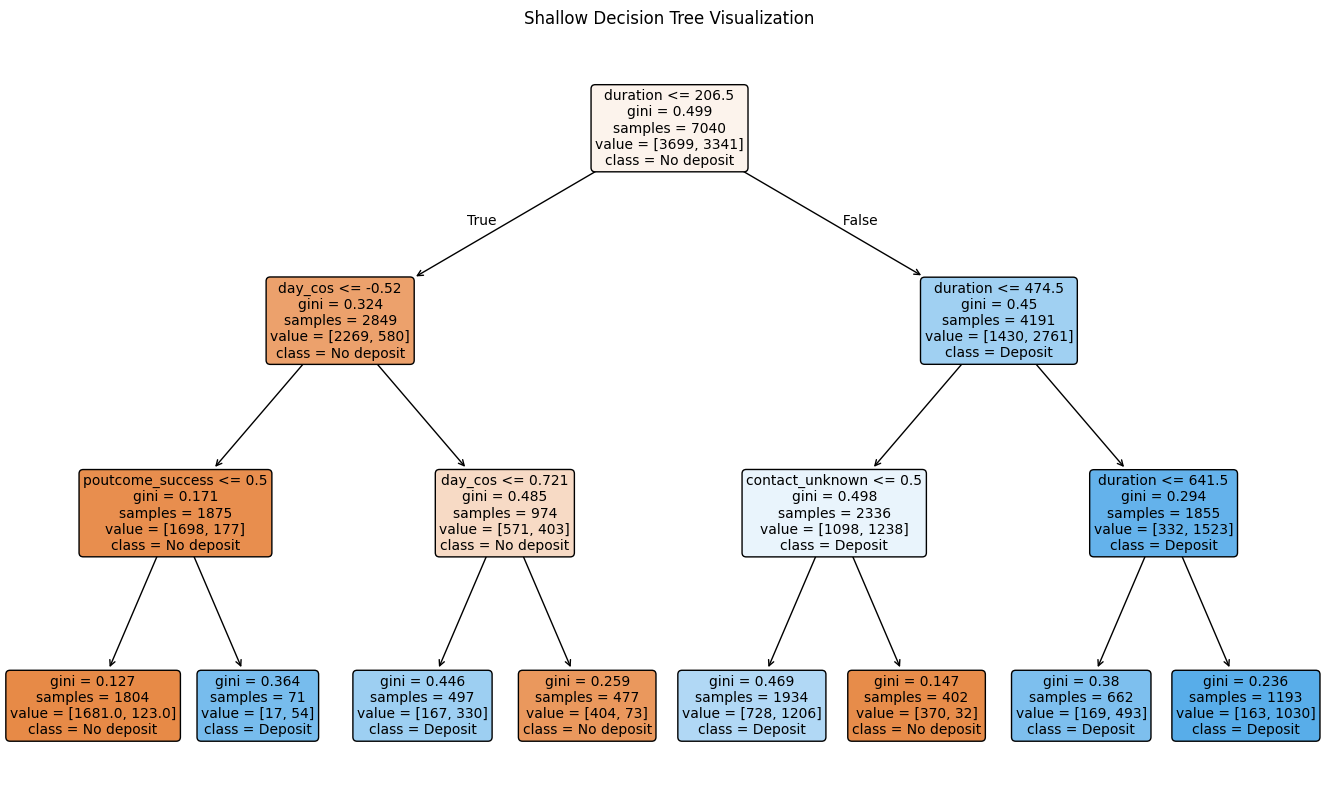

In [44]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 10))

tree.plot_tree(
    tree_pipe_shallow.named_steps["classifier"],
    feature_names=feature_names_transformed,
    class_names=["No deposit", "Deposit"],
    filled=True,
    rounded=True,
    fontsize=10
)


plt.title("Shallow Decision Tree Visualization")
plt.show()


Before analyzing the outcome, let's consider the variable named `day_cos` (observable on the left child of the root node). This feature is not a raw calendar value, but the cosine component of a cyclical encoding of the day of the year. Concretely, each date is first converted to its day-of-year index $d \in \{1,\dots,365\}$, and then mapped to the value $\cos(2\pi d / 365)$. This transformation places all days on a circle, so that dates close in the calendar (including year boundaries, such as late December and early January) are also close in the transformed space. 

As a result, splits such as `day_cos <= -0.52` do not correspond to a single specific day or month, but to a continuous region of the year where the cosine component is relatively low, roughly capturing a seasonal segment of the calendar rather than an individual date. Let's see whicht days are we talking about when considering this constraint:


In [45]:
# Create a DataFrame to illustrate the cyclical transformation for days of the year
possible_days = np.arange(1, 366) 
sin_days = np.sin(2 * np.pi * possible_days / 365)
cos_days = np.cos(2 * np.pi * possible_days / 365)

df_days = pd.DataFrame({
    "day of the year": possible_days,
    "sin": sin_days,
    "cos": cos_days
})

mask = df_days["cos"] <= -0.52
df_days_filtered = df_days[mask]
df_days_filtered.head()


,day of the year,sin,cos
123,124,0.845249,-0.534373
124,125,0.835925,-0.548843
125,126,0.826354,-0.563151
126,127,0.816538,-0.577292
127,128,0.806480,-0.591261


From this check, the constraint `day_cos <= -0.52` roughly corresponds to days 123 to 127 of the year (early–mid May), so the split is effectively isolating observations that occur around this seasonal window.


,Feature,Importance
2,duration,0.631
21,day_cos,0.183
14,contact_unknown,0.140
17,poutcome_success,0.046


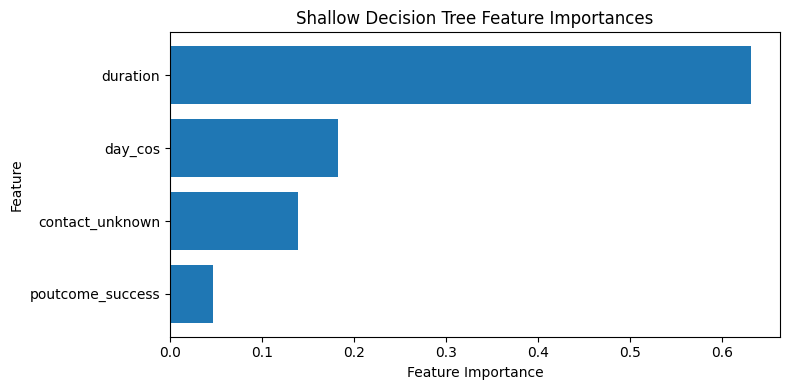

In [46]:
importances = tree_pipe_shallow.named_steps["classifier"].feature_importances_

results = pd.DataFrame({
    "Feature": feature_names_transformed[:len(importances)],
    "Importance": importances
})

# Keep only features actually used by the tree
results = results[results["Importance"] > 0].sort_values(
    "Importance", ascending=False
)

display(results.style.format({"Importance": "{:.3f}"}))

plt.figure(figsize=(8, 4))
plt.barh(results["Feature"], results["Importance"])
plt.gca().invert_yaxis()  # most important on top
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Shallow Decision Tree Feature Importances")
plt.tight_layout()
plt.show()



#### Most critical features in the shallow tree

The shallow tree clearly exposes a hierarchy of predictive power. The root split is dominated by the duration of the last contact, which is by far the most important feature (often contributing more than half of the total Gini importance). Although highly predictive, duration is only known after the call ends, so it is not suitable for pre-call lead scoring and can be seen as a “post‑hoc” driver rather than a proactive targeting feature.

Beyond duration, the tree relies on several actionable variables. `poutcome_success` (previous campaign outcome) strongly increases the baseline probability of subscription, highlighting the value of past positive interactions. The `day_cos` of contact captures seasonality and campaign timing effects, while `countact_unknown` (the contact communication type was is not known) reflects that those people which come to the bank arbitrarily are more likely to not be given the deposit that those who come from a known, controlled, and structured communication channel.. 

In summary, duration provides the strongest separation in the tree, but `poutcome_success`, `day_cos`, and `contact_unknown` are the features that truly support business strategy, as they help identify high‑quality leads before engagement and inform when and how intensively to contact clients.


 #### Most critical features in the shallow tree

The shallow tree clearly exposes a hierarchy of predictive power. The root split is dominated by the duration of the last contact, which is by far the most important feature (often contributing more than half of the total Gini importance). Although highly predictive, duration is only known after the call ends, so it is not suitable for pre-call lead scoring and can be seen as a “post‑hoc” driver rather than a proactive targeting feature.

Beyond duration, the tree relies on several actionable variables. `poutcome_success` (previous campaign outcome) strongly increases the baseline probability of subscription, highlighting the value of past positive interactions. The `month` of contact captures seasonality and campaign timing effects, while `campaign` (number of contacts) reflects diminishing returns: as the number of contact attempts grows, the likelihood of conversion tends to decrease. 

In summary, duration provides the strongest separation in the tree, but `poutcome_success`, `month`, and `campaign` are the features that truly support business strategy, as they help identify high‑quality leads before engagement and inform when and how intensively to contact clients.


***Ideal Profile to Receive the Deposit***

Customers who have longer call durations (suggesting higher engagement and interest), are contacted through known channels (e.g., telephone or cellular) rather than "unknown", and show previous positive outcomes or a history of interest in similar products are the most likely to subscribe to the deposit.

***Ideal Profile to Not Receive the Deposit***

Customers with short or zero call durations (indicating lack of interest or failure to connect), contact information marked as "unknown" or less reliable, and a history of unsuccessful past campaigns are the least likely to subscribe. 

### Trees HPO

After this, we are interested on finding which are the best hypeparameters for Trees. In this work we ars interested on tuning not only the model's internal hyperparameters but also the preprocessing steps. Threfore, we treat feature engineering decisions as search parameters inside the pipeline. To find the best trade-off between computer efficiency and optimal configuration, we compare three distinct optimization strategies, which are Grid Search, Random Search, and Optuna.

In [ ]:
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(random_state=SEED))
])

tree_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
hyperparams_tree_pre = {


    #Different encoding strategies to try

    'preprocessor__dates__encode__func': [
        identity_transform,
        cyclical_transform_365
    ],
    'preprocessor__education__encode': [
        OneHotEncoder(handle_unknown='ignore', sparse_output=False),
        OrdinalEncoder(categories=education_order, handle_unknown='use_encoded_value', unknown_value=-1),
    ],
    'preprocessor__job__encode': [
        OneHotEncoder(handle_unknown='ignore', sparse_output=False),
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    ],
    'preprocessor__marital__encode': [
        OneHotEncoder(handle_unknown='ignore', sparse_output=False),
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    ],
    

    # Different imputation strategies to try

    'preprocessor__education__imputer': [
        SimpleImputer(strategy='most_frequent'),
        SimpleImputer(strategy='constant', fill_value='unknown')
    ],
    'preprocessor__job__imputer': [
        SimpleImputer(strategy='most_frequent'),
        SimpleImputer(strategy='constant', fill_value='Unknown')
    ],
    'preprocessor__marital__imputer': [
        SimpleImputer(strategy='most_frequent'),
        SimpleImputer(strategy='constant', fill_value='Unknown')
    ],
    'preprocessor__onehot__imputer': [
        SimpleImputer(strategy='most_frequent'),
        SimpleImputer(strategy='constant', fill_value='Unknown')
    ],

    
    #Different hyperparameters to combine and try

    'classifier__max_depth': [5, 8, 10], 
    
    'classifier__min_samples_split': [5, 8, 10], 
    
    'classifier__min_samples_leaf': [2, 4, 6], 
    
    'classifier__criterion': ['gini', 'entropy']
}

No more hyperparemeter combinations can be tried due to the high computational cost. With the stablished hyperparameters, encoding and inputing strategies, almost 14k different models will be trained and compared to choose only one based on accuracy

#### Grid Search

In [82]:
grid_tree = train_and_evaluate_tree(
    X_train=X_train,
    y_train=y_train,
    tree_pipeline=tree_pipeline,
    hyperparameters=hyperparams_tree_pre,
    inner_scores_name='tree_hpo', 
    method='grid_search' 
)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


In [83]:
print("Grid Search Tree Results:")
print("Best params:", grid_tree.best_params_)
print(inner_scores['tree_hpo_grid_search'] )
print("Training time:")
print(f"{timers_models['tree_hpo_grid_search']} seconds")
grid_tree

Grid Search Tree Results:
Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 5, 'preprocessor__dates__encode__func': <function identity_transform at 0x000001B9DC8C67A0>, 'preprocessor__education__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__education__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__job__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__job__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__marital__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__onehot__imputer': SimpleImputer(strategy='most_frequent')}
0.8268465909090909
Training time:
1427.1587624549866 seconds


,estimator,Pipeline(step...=100563523))])
,param_grid,"{'classifier__criterion': ['gini'], 'classifier__max_depth': [5, 10], 'classifier__min_samples_leaf': [2, 4, ...], 'classifier__min_samples_split': [5, 8], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('onehot', ...), ...]"


#### Random Search

In [ ]:
random_tree = train_and_evaluate_tree(
    X_train=X_train,
    y_train=y_train,
    tree_pipeline=tree_pipeline,
    hyperparameters=hyperparams_tree_pre,
    inner_scores_name='tree_hpo',
    method='random_search'
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:

print("Random Search Tree Results:")
print("Best params:", random_tree.best_params_)
print(inner_scores['tree_hpo_random_search'] )
print("Training time:")
print(f"{timers_models['tree_hpo_random_search']} seconds")
random_tree

Random Search Tree Results:
Best params: {'preprocessor__onehot__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__marital__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__job__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__job__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__education__imputer': SimpleImputer(fill_value='unknown', strategy='constant'), 'preprocessor__education__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__dates__encode__func': <function identity_transform at 0x000001F0E3960360>, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 1.0, 'classifier__max_depth': 10, 'classifier__criterion': 'gini'}
0.8292613636363637
Training time:
7.3071208000183105 seconds


,estimator,Pipeline(step...=100563523))])
,param_distributions,"{'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [5, 8, ...], 'classifier__max_features': [None, 'sqrt', ...], 'classifier__min_samples_leaf': [1, 2, ...], ...}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,100563523
,error_score,nan


#### Optuna Search

In [ ]:
optuna_tree = train_and_evaluate_tree(
    X_train=X_train,
    y_train=y_train,
    tree_pipeline=tree_pipeline,
    hyperparameters=hyperparams_tree_pre,
    inner_scores_name='tree_hpo',
    method='optuna_search',
    trials=50   
)

[I 2025-12-03 23:14:10,646] A new study created in memory with name: no-name-87a9572d-54b4-45ad-8c33-2eb5b401acb2
[I 2025-12-03 23:14:13,245] Trial 0 finished with value: 0.8292613636363637 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__education__imputer': 'most_frequent', 'preprocessor__job__imputer': 'constant', 'preprocessor__marital__imputer': 'constant', 'preprocessor__onehot__imputer': 'constant', 'classifier__max_depth': 17, 'classifier__min_samples_split': 73, 'classifier__min_samples_leaf': 20, 'classifier__criterion': 'gini'}. Best is trial 0 with value: 0.8292613636363637.
[I 2025-12-03 23:14:15,090] Trial 1 finished with value: 0.7946022727272727 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ohe', 'preprocessor__job__encode': 'ord', 'preprocessor__marital__encode': 'oh

In [ ]:
print("Optuna Search Tree Results:")
print("Best params:", optuna_tree.best_params_)
print(inner_scores['tree_hpo_optuna_search'] )
print("Training time:")
print(f"{timers_models['tree_hpo_optuna_search']} seconds")

optuna_tree

Optuna Search Tree Results:
Best params: {'preprocessor__dates__encode__func': <function identity_transform at 0x000001F0E3960360>, 'preprocessor__education__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__job__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__education__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__job__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'preprocessor__marital__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__onehot__imputer': SimpleImputer(strategy='most_frequent'), 'classifier__max_depth': 25, 'classifier__min_samples_split': 62, 'classifier__min_samples_leaf': 8, 'classifier__criterion': 'gini'}
0.8376420454545455
Training time:
24.578171730041504 seconds


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Conclusions

In [43]:
df_results = pd.DataFrame({
    'model': inner_scores.keys(),
    'accuracy_inner': inner_scores.values(),
    'time_seconds': [round(timers_models[m],3) for m in inner_scores.keys()]
})

df_results


,model,accuracy_inner,time_seconds
0,dummy,0.525426,0.182
1,knn_default,0.734517,3.192
2,knn_hpo_grid_search,0.823153,7386.615
3,knn_hpo_random_search,0.822159,26.139
4,knn_hpo_optuna_search,0.818324,234.678
5,tree_default,0.790909,2.194
6,tree_hpo_grid_search,0.833239,34153.114
7,tree_hpo_random_search,0.826136,7.095
8,tree_hpo_optuna_search,0.837642,36.253


First, both KNN and Tree default models substantially outperform the Dummy baseline. Therefore, it is clear that using learned models to make predictions and extract structure from the data is preferable to relying on a naive reference model.

Trees, both without and with HPO, outperform KNN on this problem, while remaining more interpretable. 

Regarding HPO methods, Grid Search is exhaustive and often finds strong configurations. However, it is computationally expensive and quickly becomes inefficient as the search space grows. 

In the other hand, Random Search is much cheaper and can discover good models, but its results depend heavily on luck: important regions of the hyperparameter space may never be sampled, which reduces reliability.

Optuna effectively combines the strengths of both: it uses smarter, guided sampling to focus on promising regions while requiring far fewer evaluations than Grid Search and being less random than pure Random Search. It offers a much better tradeoff between computation time and performance. For this reason, we finally select Optuna as our HPO method, and the best overall model in this section is the Decision Tree with Optuna‑based hyperparameter optimization.


# 4. ADVANCED METHODS

As we are trying to find the model with the best performance, we now evaluate the performance of more advanced techniques. All these techniques combine different estimators, to get a better generalization than the previous evaluated methods. In this section we train and evaluate models that belongs to two complementary advanced strategies, which are:

- **Bagging technique**: The bagging technique tries to reduce the variance by creating multiple datasets and multiple classifiers which are then combined to make a final prediction. In our case the prediction is going to be the majority class, since we are facing a classification problem. Among all the existent ones, for this section, we select Random Forest and Extra Trees.

- **Boosting technique**: In this technique a new model is trained by sequentially learning the residual errors. Among all the existent models, we train and evaluate XGBoost and HistGradientBoosting

It is worth mentioning that we utilize the same preprocessing pipeline for all these methods, isolating the algorithm choice as the only variable. As all these techniques are based on trees, which are innmune to the scale of the data, we employ the same preprocessing step we defined in the [preprocessing of the trees](#trees_preprocessing).

For the hyperparameter optimization, we use Optuna as the search strategy because, as we saw in the previous section, it provides a good trade-off between computational cost and performance. Therefore, we create a generic class in order to make the code reusable for every tested method. As all these methods are based on decision trees, we can reuse the same preprocessing pipeline we defined for them.

In [ ]:
class OptunaSearch_AdvancedMethods(OptunaSearchBase):
    def __init__(self, model_pipeline, n_trials=50, random_state=None):
        super().__init__(model_pipeline, n_trials, random_state)
        

        self.preprocessing_config ['imputers']  = self._get_imputers()
    
    
    def _get_imputers(self):
        return {
            'job': {
                'most_frequent': SimpleImputer(strategy='most_frequent'),
                'constant': SimpleImputer(strategy='constant', fill_value='Unknown'),
            },
            'education': {
                'most_frequent': SimpleImputer(strategy='most_frequent'),
                'constant': SimpleImputer(strategy='constant', fill_value='unknown'),
            },
            'marital': {
                'most_frequent': SimpleImputer(strategy='most_frequent'),
                'constant': SimpleImputer(strategy='constant', fill_value='Unknown'),
            }
        }

    def objective(self, trial, X_train, y_train):

        super().objective(trial, X_train, y_train)
        
        edu_imputer = trial.suggest_categorical(
            "preprocessor__education__imputer",
            list(self.preprocessing_config['imputers']['education'].keys())
        )
        job_imputer = trial.suggest_categorical(
            "preprocessor__job__imputer",
            list(self.preprocessing_config['imputers']['job'].keys())
        )
        marital_imputer = trial.suggest_categorical(
            "preprocessor__marital__imputer",
            list(self.preprocessing_config['imputers']['marital'].keys())
        )

        self.model = clone(self.model_pipeline)
        self.model.set_params(
            preprocessor__education__imputer  = self.preprocessing_config['imputers']['education'][edu_imputer],
            preprocessor__job__imputer        = self.preprocessing_config['imputers']['job'][job_imputer],
            preprocessor__marital__imputer    = self.preprocessing_config['imputers']['marital'][marital_imputer],
        )
    
    def decode_params(self, params):
        decoded_params = super().decode_params(params)
        decoded_params['preprocessor__education__imputer'] = self.preprocessing_config['imputers']['education'][params['preprocessor__education__imputer']]
        decoded_params['preprocessor__job__imputer'] = self.preprocessing_config['imputers']['job'][params['preprocessor__job__imputer']]
        decoded_params['preprocessor__marital__imputer'] = self.preprocessing_config['imputers']['marital'][params['preprocessor__marital__imputer']]
        return decoded_params

    

## Bagging technique

### Random Forest

We firstly evaluate the performance of Random Forest, which constructs a big number of decision trees and fits them using different sub-samples of the dataset, which are randomly selected. Then it computes the entropies of the features in each tree to determine the most important ones. Finally, it combines the predictions of all the trees to make a final prediction. As weell as for the previous models, we first evaluate the default hyperparameters and then we perform hyperparameter optimization using Optuna. The hyperparameters of this model are:
- `n_estimators`: This hyperparameter represents tha number of trees in the forest. Augmenting this number stabilizes the training because it reduces the variance. In scikit-learn, the default value is 100. The higher the number of trees, the better the performance, but also the computational cost increases. This is not a real hyperparameter because the model performance keeps improving with more trees, but we evaluate different values to better control the computational cost of the model.

- `criterion`: This hyperparameter represents the function to measure the quality of a split. In scikit-learn, the default value is 'gini'.
- `max_depth`: This is the maximum depth of the tree. That is, the longest number of nodes from the root to a leaf. In scikit-learn, the default value is None, which means that nodes are expanded until all leaves are pure (we cannot split anything).

- `max_features`: Indicates the maximum number of features to consider comming from the each tree in the random forest when looking for the best split. In scikit-learn, the default value is 'sqrt'.

- `max_leaf_nodes`: This hyperparameter indicates the maximum number of leaf nodes in the tree, thus restricting its growth. In scikit-learn, the default value is None, which means that nodes are expanded until all leaves are pure.

- `max_samples`: It determines the maximum number of samples to get to train each base estimator. Is a fraction. In scikit-learn, the default value is None, which means that all the samples are used to train each tree.
- `min_samples_leaf`: The hyperparameter specifies the minimum number of samples required to be at a leaf node. In scikit-learn, the default value is 1.

- `min_samples_split`: The hyperparameter tells the decision tree which are the minimum number of samples required to split an internal node. In scikit-learn, the default value is 2.
- `bootstrap`: This hyperparameters indicates how samples are drawn to train each base estimator. In scikit-learn, the default value is True, which means that samples are drawn with replacement. If this parameter is set to False, samples are drawn without replacement. We evaluate this parameter during the hyperparameter optimization phase because in cases of small datasets, using sampling with replacement can lead to some samples being repeated multiple times in the training set for a given tree, while others are left out. 

In [74]:
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', RandomForestClassifier(random_state=SEED))
])
random_forest_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('pdays', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [62]:
start_time = time.time()
scores=cross_val_score(random_forest_pipeline, X_train, y_train, cv=inner, scoring='accuracy', n_jobs=-1).mean()
end_time = time.time()
timers_models['random_forest_default'] = end_time - start_time
inner_scores['random_forest_default'] = scores
print("Random Forest CV Accuracy Results:")
print(scores)
print("Training time:")
print(f"{timers_models['random_forest_default']} seconds")

Random Forest CV Accuracy Results:
0.8536931818181819
Training time:
1.2420029640197754 seconds


In order to get the best hyperparameters, we define a search space for each hyperparameter and then we leverage Optuna to find the best combination. As well as we did in previous sections, we create a class that extends the OptunaSearchBase class to reuse the code.

In [ ]:
class OptunaSearch_RandomForest(OptunaSearch_AdvancedMethods):
    def __init__(self, model_pipeline, n_trials=50, random_state=SEED):
        super().__init__(model_pipeline, n_trials, random_state)
    def objective(self, trial, X_train, y_train):

        super().objective(trial, X_train, y_train)

        max_depth = trial.suggest_int("classifier__max_depth", 2, 40)
        min_samples_split = trial.suggest_int("classifier__min_samples_split", 2, 100)
        min_samples_leaf = trial.suggest_int("classifier__min_samples_leaf", 1, 20)
        criterion = trial.suggest_categorical("classifier__criterion", ["gini", "entropy"])
        n_estimators = trial.suggest_int("classifier__n_estimators", 50, 300, step=50)
        bootstrap = trial.suggest_categorical("classifier__bootstrap", [True, False])
        max_features = trial.suggest_categorical("classifier__max_features", ["sqrt", "log2"])
        bootstrap = trial.suggest_categorical("classifier__bootstrap", [True, False])

        if bootstrap:
            max_samples = trial.suggest_float("classifier__max_samples", 0.5, 1.0)
        else:
            max_samples = None
        
        limit_depth = trial.suggest_categorical("limit_depth", [True, False])
        if not limit_depth:
            max_depth = None
        


        self.model.set_params(
            # Model parameters
            classifier__max_depth             = max_depth,
            classifier__min_samples_split     = min_samples_split,
            classifier__min_samples_leaf      = min_samples_leaf,
            classifier__criterion             = criterion,
            classifier__n_estimators          = n_estimators,
            classifier__bootstrap             = bootstrap,
            classifier__max_features          = max_features,
            classifier__max_samples           = max_samples
        )

        
        scores = cross_val_score(self.model, X_train, y_train, cv=inner, scoring='accuracy', n_jobs=-1)
        return scores.mean()

    def fit(self, X, y):
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
        study.optimize(lambda trial: self.objective(trial, X, y), n_trials=self.n_trials)
        self.best_params_ = self.decode_params(study.best_params)
        final_params = self.best_params_.copy()
        if 'limit_depth' in final_params:
            if not final_params['limit_depth']:
                final_params['classifier__max_depth'] = None
            del final_params['limit_depth']
        self.best_score_ = study.best_value
        self.best_model_ = clone(self.model_pipeline)
        self.best_model_.set_params(**final_params)
        self.best_model_.fit(X, y)
        return self

    
    
        

In [118]:
random_search_hpo = OptunaSearch_RandomForest(random_forest_pipeline,50)
start_time = time.time()
random_search_hpo.fit(X_train,y_train)
end_time = time.time()
inner_scores['random_forest_hpo_optuna_search'] = random_search_hpo.best_score_
timers_models['random_forest_hpo_optuna_search'] = end_time - start_time

[I 2025-12-09 19:28:16,496] A new study created in memory with name: no-name-0c7028f7-02ba-4601-bec0-eef4b19963de
[I 2025-12-09 19:28:18,800] Trial 0 finished with value: 0.8458806818181819 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__education__imputer': 'most_frequent', 'preprocessor__job__imputer': 'constant', 'preprocessor__marital__imputer': 'constant', 'classifier__max_depth': 18, 'classifier__min_samples_split': 57, 'classifier__min_samples_leaf': 8, 'classifier__criterion': 'entropy', 'classifier__n_estimators': 250, 'classifier__bootstrap': True, 'classifier__max_features': 'log2', 'classifier__max_samples': 0.6554921228740318, 'limit_depth': False}. Best is trial 0 with value: 0.8458806818181819.
[I 2025-12-09 19:28:20,422] Trial 1 finished with value: 0.8522727272727272 and parameters: {'preprocessor__dates__encode__func': 

In [119]:
print("Optuna Search Random Forest Results:")
print("Best params:", random_search_hpo.best_params_)
print(inner_scores['random_forest_hpo_optuna_search'] )
print("Training time:")
print(f"{timers_models['random_forest_hpo_optuna_search']} seconds")

Optuna Search Random Forest Results:
Best params: {'preprocessor__dates__encode__func': <function cyclical_transform_365 at 0x000001E2BF609D00>, 'preprocessor__education__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__marital__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__education__imputer': SimpleImputer(fill_value='unknown', strategy='constant'), 'preprocessor__job__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'preprocessor__marital__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'classifier__max_depth': 32, 'classifier__min_samples_split': 14, 'classifier__min_samples_leaf': 5, 'classifier__criterion': 'gini', 'classifier__n_estimators': 150, 'classifier__bootstrap': False, 'classifier__max_features': 'sqrt', 'limit_depth': False}
0.8583806818181818
Training time:
1

### Extra Trees

Extra Trees (Extremely Randomized Trees) is an ensemble method that constructs a large number of decision trees and trains them on the full dataset without bootstrap sampling by default. The key distinguishing feature is that instead of searching for the best split threshold for each feature, Extra Trees draws random thresholds and selects the best among these random splits. This increases randomization and reduces training time. Finally, it combines the predictions of all trees to make a final prediction. As with the previous models, we first evaluate the default hyperparameters and then perform hyperparameter optimization using Optuna. The hyperparameters of this model are:

- `n_estimators`: This hyperparameter represents the number of trees in the ensemble. Increasing this number stabilizes the training because it reduces the variance. In scikit-learn, the default value is 100. The higher the number of trees, the better the performance, but also the computational cost increases.

- `criterion`: This hyperparameter represents the function to measure the quality of a split. In scikit-learn, the default value is `'gini'`.

- `max_depth`: This is the maximum depth of each tree. That is, the longest number of nodes from the root to a leaf. In scikit-learn, the default value is `None`, which means that nodes are expanded until all leaves are pure (we cannot split anything).

- `max_features`: Indicates the maximum number of features to consider in each tree when looking for the best split. In scikit-learn, the default value is `'sqrt'` for classification.

- `max_samples`: It determines the maximum number of samples (or fraction thereof) to use for training each base estimator. In scikit-learn, the default value is `None`, which means that all the samples are used to train each tree. When set to a value less than 1.0, it enables subsampling without replacement.

- `min_samples_leaf`: The hyperparameter specifies the minimum number of samples required to be at a leaf node. In scikit-learn, the default value is 1. Increasing this value can help reduce overfitting by smoothing the model.

- `min_samples_split`: The hyperparameter tells each tree the minimum number of samples required to split an internal node. In scikit-learn, the default value is 2. Higher values prevent splits supported by too few samples.

- `bootstrap`: This hyperparameter indicates how samples are drawn to train each base estimator. In scikit-learn, the default value is `False` for Extra Trees (unlike Random Forest), which means samples are drawn without replacement. If set to `True`, samples are drawn with replacement. We may evaluate this parameter during the hyperparameter optimization phase because it affects the diversity of the trees and the ability to compute out-of-bag scores.


In [87]:
extra_trees_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', ExtraTreesClassifier(random_state=SEED))
])
extra_trees_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
start_time = time.time()
scores=cross_val_score(extra_trees_pipeline, X_train, y_train, cv=inner, scoring='accuracy', n_jobs=-1).mean()
end_time = time.time()
timers_models['extra_trees_default'] = end_time - start_time
inner_scores['extra_trees_default'] = scores
print("Extra Trees CV Accuracy Results:")
print(scores)
print("Training time:")
print(f"{timers_models['extra_trees_default']} seconds")

Extra Trees CV Accuracy Results:
0.8276988636363637
Training time:
31.723655939102173 seconds


Using the same workflow as we did in Random Forest, we define a search space for each hyperparameter and then we leverage Optuna to find the best combination. Also, we create a class that extends the OptunaSearchBase class to reuse the code.

In [88]:
class OptunaSearch_ExtraTrees(OptunaSearch_AdvancedMethods):
    def __init__(self, model_pipeline, n_trials=50, random_state=SEED):
        super().__init__(model_pipeline, n_trials, random_state)

    def objective(self, trial, X_train, y_train):

        super().objective(trial, X_train, y_train)

        # Model hyperparameters to tune
        max_depth = trial.suggest_int("classifier__max_depth", 2, 30)
        min_samples_split = trial.suggest_int("classifier__min_samples_split", 2, 50)
        min_samples_leaf = trial.suggest_int("classifier__min_samples_leaf", 1, 20)
        criterion = trial.suggest_categorical("classifier__criterion", ["gini", "entropy"])
        n_estimators = trial.suggest_int("classifier__n_estimators", 50, 300, step=50)
        max_features = trial.suggest_categorical("classifier__max_features", ["sqrt", "log2", None])
        bootstrap = trial.suggest_categorical("classifier__bootstrap", [True, False])

        if bootstrap:
            max_samples = trial.suggest_float("classifier__max_samples", 0.5, 1.0)
        else:
            max_samples = None

        self.model.set_params(

            # Model parameters
            classifier__max_depth         = max_depth,
            classifier__min_samples_split = min_samples_split,
            classifier__min_samples_leaf  = min_samples_leaf,
            classifier__criterion         = criterion,
            classifier__n_estimators      = n_estimators,
            classifier__bootstrap         = bootstrap,
            classifier__max_features      = max_features,
            classifier__max_samples       = max_samples
        )

        scores = cross_val_score(
            self.model, X_train, y_train,
            cv=inner, scoring='accuracy', n_jobs=-1
        )
        return scores.mean()



In [29]:
extra_trees_hpo = OptunaSearch_ExtraTrees(extra_trees_pipeline,50)
start_time = time.time()
extra_trees_hpo.fit(X_train,y_train)
end_time = time.time()
inner_scores['extra_trees_hpo_optuna_search'] = extra_trees_hpo.best_score_
timers_models['extra_trees_hpo_optuna_search'] = end_time - start_time

[I 2025-12-17 16:57:03,801] A new study created in memory with name: no-name-84bbf3ea-7b06-4acf-a54d-db51ba121805
[I 2025-12-17 16:57:10,273] Trial 0 finished with value: 0.7887784090909091 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__education__imputer': 'most_frequent', 'preprocessor__job__imputer': 'constant', 'preprocessor__marital__imputer': 'constant', 'classifier__max_depth': 13, 'classifier__min_samples_split': 29, 'classifier__min_samples_leaf': 8, 'classifier__criterion': 'entropy', 'classifier__n_estimators': 250, 'classifier__max_features': 'sqrt', 'classifier__bootstrap': True, 'classifier__max_samples': 0.5063624675871093}. Best is trial 0 with value: 0.7887784090909091.
[I 2025-12-17 16:57:12,549] Trial 1 finished with value: 0.7758522727272729 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preproces

In [30]:
print("Optuna Search Extra Trees Results:")
print("Best params:", extra_trees_hpo.best_params_)
print(inner_scores['extra_trees_hpo_optuna_search'])
print("Training time:")
print(f"{timers_models['extra_trees_hpo_optuna_search']} seconds")

Optuna Search Extra Trees Results:
Best params: {'preprocessor__dates__encode__func': <function identity_transform at 0x000002D560D78360>, 'preprocessor__education__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__job__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__marital__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__education__imputer': SimpleImputer(fill_value='unknown', strategy='constant'), 'preprocessor__job__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'preprocessor__marital__imputer': SimpleImputer(strategy='most_frequent'), 'classifier__max_depth': 24, 'classifier__min_samples_split': 24, 'classifier__min_samples_leaf': 1, 'classifier__criterion': 'gini', 'classifier__n_estimators': 50, 'classifier__max_features': None, 'classifier__bootstrap': False}
0.8508522727272727
Training time:
112.58371901512146 seconds


## Boosting technique

### XGBoost

We now evaluate the performance of XGBoost, which is an optimized implementation of the gradient boosting technique. Therefore, XGBoost builds new decission trees that try to correct the errors made by the previous ones. It finally combines all the prediction of all trees to get a final prediction. As well as for the previous models, we first evaluate the default hyperparameters and then we perform hyperparameter optimization using Optuna. The key [hyperparameters](https://xgboost.readthedocs.io/en/stable/parameter.html) of this model are:
 - `n_estimators`: This hyperparameter represents tha number of trees in the forest. Contrary to bagging techniques, in boosting technique, having too many trees can lead to overfitting because the new trees try to correct all the errors of the previous ones, including those caused by noise. The default value is 100.
 - `learning_rate`: This hyperparameter controls the contribution of each tree to the final prediction. A smaller learning rate means that each tree has a smaller impact, requiring more trees to fit the data well. The default value is 0.5.
- `max_depth`: The hyperparameter represents the maximum depth of the tree. As well as with the estimators, having too many levels help us to fit the training data better, but also can lead to overfitting. The default value is 3.
- `subsample`: This indicates the fraction of samples the model uses to train each tree. Using a value less than 1.0 introduces randomness, which can help prevent overfitting. The default value is 1.0.

- `colsample_bytree`: This hyperparameter indicates the fraction of features (columns) the model uses to train each tree. Using a value less than 1.0 introduces randomness, which can help prevent overfitting. The default value is 1.0.

- `min_child_weight`: This hyperparameter specifies the minimum sum of instance weight needed in a child. It is used to control overfitting. Higher values prevent the model from learning relations which might be highly specific to the particular sample selected for a tree. The default value is 1.

For the objective, we use 'binary:logistic' because we are facing a binary classification problem and we want to get the probability that a given sample belongs to the positive class for a further study. We also employ the 'logloss' eval_metric because it is suitable for binary classification problems. Finally we also employ the booster 'gbtree' because we are using decision trees as base estimators because they are effective for handling structured data and can capture complex interactions between features. These last two parameters are not explicitly declared because they are the default ones.


In [ ]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', xgb.XGBClassifier(random_state=SEED, objective='binary:logistic'))
])
xgb_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [150]:
xgb_start_time = time.time()
scores=cross_val_score(xgb_pipeline, X_train, y_train, cv=inner, scoring='accuracy', n_jobs=-1).mean()
xgb_end_time = time.time()
timers_models['xgb_default'] = xgb_end_time - xgb_start_time
inner_scores['xgb_default'] = scores
print("XGBoost CV Accuracy Results:")
print(scores)
print("Training time:")
print(f"{timers_models['xgb_default']} seconds")

XGBoost CV Accuracy Results:
0.8573863636363637
Training time:
0.5325500965118408 seconds


As well as we did in previous sections, we create a class that extends the OptunaSearchBase class to reuse the code. However in this case, we implement what is called early stopping to prevent overfitting. This technique consists on stopping the training if the model does not improve its performance after a certain number of iterations. In our case, we set this number to 10.

In [ ]:
class OptuanSearch_XGB(OptunaSearch_AdvancedMethods):
    def __init__(self, model_pipeline, n_trials=50, random_state=SEED):
        super().__init__(model_pipeline, n_trials, random_state)
    def objective(self, trial, X_train, y_train):

        super().objective(trial, X_train, y_train)

        n_estimators = trial.suggest_int("classifier__n_estimators", 50, 300, step=50)
        max_depth = trial.suggest_int("classifier__max_depth", 2, 20)
        learning_rate = trial.suggest_float("classifier__learning_rate", 0.01, 0.3, step=0.01)
        subsample = trial.suggest_float("classifier__subsample", 0.5, 1.0, step=0.1)
        colsample_bytree = trial.suggest_float("classifier__colsample_bytree", 0.5, 1.0, step=0.1)
        min_child_weight = trial.suggest_int("classifier__min_child_weight", 1, 10)


        self.model.set_params(
            classifier__n_estimators      = n_estimators,
            classifier__max_depth         = max_depth,
            classifier__learning_rate     = learning_rate,
            classifier__subsample         = subsample,
            classifier__colsample_bytree  = colsample_bytree,
            classifier__min_child_weight   = min_child_weight
        )

        
        scores = cross_val_score(self.model, X_train, y_train, cv=inner, scoring='accuracy', n_jobs=-1)
        return scores.mean()

In [47]:

xgboost_hpo = OptuanSearch_XGB(xgb_pipeline,50)
xgb_start_time = time.time()
xgboost_hpo.fit(X_train,y_train)
xgb_end_time = time.time()
inner_scores['xgb_hpo_optuna_search'] = xgboost_hpo.best_score_
timers_models['xgb_hpo_optuna_search'] = xgb_end_time - xgb_start_time


[I 2025-12-16 18:46:44,225] A new study created in memory with name: no-name-a85fcdd7-597b-4690-9f3c-21fb8f8bae83
[I 2025-12-16 18:46:44,843] Trial 0 finished with value: 0.8592329545454545 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__education__imputer': 'most_frequent', 'preprocessor__job__imputer': 'constant', 'preprocessor__marital__imputer': 'constant', 'classifier__n_estimators': 150, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.12, 'classifier__subsample': 0.9, 'classifier__colsample_bytree': 1.0, 'classifier__min_child_weight': 8}. Best is trial 0 with value: 0.8592329545454545.
[I 2025-12-16 18:46:45,609] Trial 1 finished with value: 0.8511363636363637 and parameters: {'preprocessor__dates__encode__func': 'identity', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__ma

In [ ]:
print("Optuna Search XGBoost Results:")
print("Best params:", xgboost_hpo.best_params_)
print(inner_scores['xgb_hpo_optuna_search'] )
print("Training time:")
print(f"{timers_models['xgb_hpo_optuna_search']} seconds")

Optuna Search XGBoost Results:
Best params: {'preprocessor__dates__encode__func': <function identity_transform at 0x000001E2BF608540>, 'preprocessor__education__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__education__imputer': SimpleImputer(fill_value='unknown', strategy='constant'), 'preprocessor__job__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'preprocessor__marital__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'classifier__n_estimators': 200, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.03, 'classifier__subsample': 0.9, 'classifier__colsample_bytree': 1.0, 'classifier__min_child_weight': 8}
0.8661931818181818
Training time:
79.67887449264526 seconds


### CatBoost

We also evaluate the performance of CatBoost, which is another optimized implementation of the gradient boosting technique. Therefore, CatBoost builds new decission trees that try to correct the errors made by the previous ones. It finally combines all the prediction of all trees to get a final prediction. As well as for the previous models, we first evaluate the default hyperparameters and then we perform hyperparameter optimization using Optuna. The key [hyperparameters](https://catboost.ai/docs/en/concepts/parameter-tuning) of this model are:
 - `iterations`: This hyperparameter represents tha number of trees in the forest. The default value is [1000](https://catboost.ai/docs/en/references/training-parameters/common).
 - `learning_rate`: This hyperparameter controls the contribution of each tree to the final prediction. By default, the learning rate is automatically set based on the number of iterations to balance convergence speed and accuracy.
- `depth`: The hyperparameter represents the maximum depth of the tree. The default value is 6.
- `l2_leaf_reg`: This hyperparameter specifies the coefficient at the L2 regularization term of the cost function. It is used to control overfitting. The default value is 3.
- `random_strength`: This hyperparameter sets the amount of randomness the algorithm must use to score splits when building trees. The default value is 1.0.
- `bagging_temperature`: This hyperparameter defines the temperature parameter for Bayesian bagging. The higher the temperature, the more aggressive the bagging. The default value is 1.0.
- `border_count`: This hyperparameter specifies the number of splits for numerical features. The default value is 254.
- `grow_policy`: This hyperparameter determines the tree growth policy. The default value is 'SymmetricTree', which grows balanced trees. But we also want to evaluate 'Depthwise', which grows trees by depth until it reaches the specified depth; and 'Lossguide', which grows trees by leaf until it reaches the specified leaf, because they can provide better performance in some cases.

In [89]:
cat_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', CatBoostClassifier(
        random_seed=SEED,
        verbose=0,
        loss_function="Logloss",
        allow_writing_files=False
    ))
])

start = time.time()
cat_default_score = cross_val_score(
    cat_pipeline, X_train, y_train,
    cv=inner, scoring="accuracy", n_jobs=-1
).mean()
end = time.time()

inner_scores["catboost_default"] = cat_default_score
timers_models["catboost_default"] = end - start

print("CatBoost default accuracy:", cat_default_score)
print("Time:", timers_models["catboost_default"])

CatBoost default accuracy: 0.8681818181818182
Time: 40.57652425765991


In order to get the best hyperparameters, we define a search space for each hyperparameter and then we leverage Optuna to find the best combination. As well as we did in previous sections, we create a class that extends the OptunaSearchBase class to reuse the code. The evaluated hyperparameters are gotten from this [link](https://catboost.ai/docs/en/concepts/parameter-tuning). We do not find ethe best hyperparameter for the learninr rate because it is automatically set based on the number of iterations.

In [56]:
class OptunaSearch_CatBoost(OptunaSearch_AdvancedMethods):
    def __init__(self, model_pipeline, n_trials=50, random_state=SEED):
        super().__init__(model_pipeline, n_trials, random_state)

    def objective(self, trial, X_train, y_train):
        super().objective(trial, X_train, y_train)

        iterations = trial.suggest_int("classifier__iterations", 100, 1200, step=100)
        depth = trial.suggest_int("classifier__depth", 4, 10)
        l2_leaf_reg = trial.suggest_float("classifier__l2_leaf_reg", 1.0, 10.0)
        random_strength = trial.suggest_float("classifier__random_strength", 0.0, 2.0)
        bagging_temperature = trial.suggest_float("classifier__bagging_temperature", 0.0, 1.0)
        border_count = trial.suggest_int("classifier__border_count", 32, 255)
        grow_policy = trial.suggest_categorical(
            "classifier__grow_policy",
            ["SymmetricTree", "Depthwise", "Lossguide"]
        )

        self.model.set_params(
            classifier__iterations=iterations,
            classifier__depth=depth,
            classifier__l2_leaf_reg=l2_leaf_reg,
            classifier__random_strength=random_strength,
            classifier__bagging_temperature=bagging_temperature,
            classifier__border_count=border_count,
            classifier__grow_policy=grow_policy
        )

        scores = cross_val_score(
            self.model, X_train, y_train, cv=inner, scoring="accuracy", n_jobs=-1
        )
        return scores.mean()


In [ ]:
cat_hpo = OptunaSearch_CatBoost(cat_pipeline, n_trials=50)

start = time.time()
cat_hpo.fit(X_train, y_train)
end = time.time()

inner_scores["catboost_hpo_optuna_search"] = cat_hpo.best_score_
timers_models["catboost_hpo_optuna_search"] = end - start

print("CatBoost Optuna best score:", inner_scores["catboost_hpo_optuna_search"])
print("CatBoost Optuna best params:", cat_hpo.best_params_)
print("Time:", timers_models["catboost_hpo_optuna_search"])


[I 2025-12-16 20:43:58,719] A new study created in memory with name: no-name-68303280-104d-4fab-9070-75f8ce6dc4dd
[I 2025-12-16 20:44:08,918] Trial 0 finished with value: 0.8677556818181819 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__education__imputer': 'most_frequent', 'preprocessor__job__imputer': 'constant', 'preprocessor__marital__imputer': 'constant', 'classifier__iterations': 500, 'classifier__depth': 7, 'classifier__l2_leaf_reg': 4.524157201932811, 'classifier__random_strength': 1.4360573880488803, 'classifier__bagging_temperature': 0.9972010344110641, 'classifier__border_count': 200, 'classifier__grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.8677556818181819.
[I 2025-12-16 20:44:12,370] Trial 1 finished with value: 0.8524147727272726 and parameters: {'preprocessor__dates__encode__func': 'identity', 'preproces

CatBoost Optuna best score: 0.8704545454545455
CatBoost Optuna best params: {'preprocessor__dates__encode__func': <function identity_transform at 0x00000175CCC5C2C0>, 'preprocessor__education__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__education__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__job__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__marital__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'classifier__iterations': 600, 'classifier__depth': 10, 'classifier__l2_leaf_reg': 4.698198315889567, 'classifier__random_strength': 1.942942935278962, 'classifier__bagging_temperature': 0.7584173465891255, 'classifier__border_count': 239, 'classifier__grow_policy': 'Lossguide'}
Time: 726.53752

In the previous cell we can see that after performing the hyperparameter optimizatin we get a very low improvement compared to the default model. This is probably because the default hyperparameters are already well suited for this specific problem, thus making that the HPO phase is not worth it.

### LightGBM

LighthGBM is another gradient boosting framework. It is mainly designed to be fast and efficient and, as well as theo other gradient boosting frameworks, it builds new decission trees that try to correct the errors made by the previous ones. It finally combines all the prediction of all trees to get a final prediction. As well as for the previous models, we first evaluate the default hyperparameters and then we perform hyperparameter optimization using Optuna. The key [hyperparameters](https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html#for-better-accuracy) of this model are to get a better accuracy are:
 - `n_estimators`: This hyperparameter represents tha number of trees in the forest. The default value is 100.
 - `learning_rate`: This hyperparameter controls the contribution of each tree to the final prediction. A smaller learning rate means that each tree has a smaller impact, requiring more trees to fit the data well. The default value is 0.1.
 - `num_leaves`: This hyperparameter represents the maximum number of leaves in one tree. The default value is 31.
 - `max_depth`: This hyperparameter is used to limit the depth of the the tree to prevent overfitting. The default value is -1, which means no limit. According to the [documentation](https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html), if we explicitly set this parameter, we also need to set `num_leaves` to some value <= 2^max_depth.
 - `min_data_in_leaf`: This hyperparameter specifies the minimum number of data points that must be present in a leaf. It is used to control overfitting. The default value is 20.
 
The same [page](https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html#deal-with-over-fitting) make us think that the `feature_fraction` hyperparameter can help us to get a better accuracy. This hyperparameter indicates the fraction of features (columns) the model uses to train each tree. Using a value less than 1.0 introduces randomness, which can help prevent overfitting. The default value is 1.0.

We also think that in order to deal with the possible overfitting, it would be also interesting to take into account the hyperparameters `bagging_fraction`  and `bagging_freq`. The first one indicates the fraction of data to be used for each iteration. The second one indicates the frequency for bagging. For example, if bagging_freq=5, then bagging will be performed in every 5 iterations. The default value for `bagging_freq` hyperparameter is 0, which means that bagging is not used.

Furthermore, we also believe that the `lambda_l1` and `lambda_l2` hyperparameters can help us to get a better accuracy. These hyperparameters specify the L1 and L2 regularization terms respectively. They are used to control overfitting. The default value for both hyperparameters is 0.0. Regarding the regularization, we also think that the `min_gain_to_split` hyperparameter can help us to get a better accuracy. This hyperparameter specifies the minimum gain to perform a split. The default value is 0.0.

`min_sum_hessian_in_leaf` is another hyperparameter that we think can help us to get a better accuracy. This hyperparameter specifies the minimum sum of hessian in one leaf. It is used to control overfitting. The default value is 1e-3.

And finally, we think that `path_smooth` and `extra_trees` hyperparameters can help us to get a better accuracy. The first one is used to avoid overfitting by smoothing the tree splits. The second one indicates whether to use extra trees or not. The default value for `extra_trees` is False and for `path_smooth` is 0.0.

In [ ]:
from lightgbm import LGBMClassifier

lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', LGBMClassifier(
        random_state=SEED,
        verbosity=-1,
        objective = "binary"
    ))
])
lgbm_pipeline


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
start = time.time()
scores = cross_val_score(lgbm_pipeline, X_train, y_train, cv=inner, scoring='accuracy', n_jobs=-1).mean()
end = time.time()

inner_scores['lgbm_default'] = scores
timers_models['lgbm_default'] = end - start

print("LightGBM default CV accuracy:", scores)
print("Time:", timers_models['lgbm_default'])


LightGBM default CV accuracy: 0.8667613636363637
Time: 7.928941249847412


To conduct the hyperparameter optimization, we create a class that extends the OptunaSearchBase class to reuse the code. The evaluated hyperparameters are gotten from this [link](https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html#for-better-accuracy).

As this page also suggests the use of dart booster to get a better accuracy, we also evaluate this booster. Dart is a boosting methods wchich tries to reduce the overfitting probability by randomly dropping some trees during the trainning. Therefore we also need to tune some additional hyperparameters for this booster, which are:
- `drop_rate`: Indicates the probability of dropping a tree during trainning.
-  `max_drop`: Indicates the maximum number of trees that can be dropped during trainning.
-  `skip_drop`: Indicates the probability of skipping the dropout procedure during training.
-  `uniform_drop`: A boolean parameter that indicates whether to use uniform drop or not.

In [ ]:
class OptunaSearch_LightGBM(OptunaSearch_AdvancedMethods):
    def __init__(self, model_pipeline, n_trials=50, random_state=SEED):
        super().__init__(model_pipeline, n_trials, random_state)

    def objective(self, trial, X_train, y_train):
        super().objective(trial, X_train, y_train)

        n_estimators = trial.suggest_int("classifier__n_estimators", 100, 1000, step=100)
        learning_rate = trial.suggest_float("classifier__learning_rate", 0.01, 0.3, log=True)

        num_leaves = trial.suggest_int("classifier__num_leaves", 16, 256, step=16)
        max_depth = trial.suggest_int("classifier__max_depth", 3, 12)

        min_data_in_leaf = trial.suggest_int("classifier__min_data_in_leaf", 20, 200, step=10)

        boosting_type = trial.suggest_categorical("classifier__boosting_type", ["gbdt", "dart"])
        feature_fraction = trial.suggest_float("classifier__feature_fraction", 0.6, 1.0, step=0.1)

        bagging_fraction = trial.suggest_float("classifier__bagging_fraction", 0.6, 1.0, step=0.1)
        bagging_freq = trial.suggest_int("classifier__bagging_freq", 0, 10)


        lambda_l1 = trial.suggest_float("classifier__lambda_l1", 1e-8, 10.0, log=True)
        lambda_l2 = trial.suggest_float("classifier__lambda_l2", 1e-8, 10.0, log=True)
        min_gain_to_split = trial.suggest_float("classifier__min_gain_to_split", 0.0, 1.0)

        min_sum_hessian_in_leaf = trial.suggest_float(
            "classifier__min_sum_hessian_in_leaf", 1e-3, 10.0, log=True
        )


        path_smooth = trial.suggest_float("classifier__path_smooth", 0.0, 50.0)
        extra_trees = trial.suggest_categorical("classifier__extra_trees", [True, False])

        params = {
            "classifier__boosting_type": boosting_type,
            "classifier__n_estimators": n_estimators,
            "classifier__learning_rate": learning_rate,
            "classifier__num_leaves": num_leaves,
            "classifier__max_depth": max_depth,
            "classifier__min_data_in_leaf": min_data_in_leaf,
            "classifier__verbosity": -1,
            "classifier__feature_fraction": feature_fraction,
            "classifier__bagging_fraction": bagging_fraction,
            "classifier__bagging_freq": bagging_freq,
            "classifier__lambda_l1": lambda_l1,
            "classifier__lambda_l2": lambda_l2,
            "classifier__min_gain_to_split": min_gain_to_split,
            "classifier__min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "classifier__path_smooth": path_smooth,
            "classifier__extra_trees": extra_trees,
        }

        if boosting_type == "dart":
            params.update({
                "classifier__drop_rate": trial.suggest_float("classifier__drop_rate", 0.1, 0.5),
                "classifier__skip_drop": trial.suggest_float("classifier__skip_drop", 0.1, 0.5),
                "classifier__max_drop": trial.suggest_int("classifier__max_drop", 10, 100),
                "classifier__uniform_drop": trial.suggest_categorical("classifier__uniform_drop", [True, False]),
            })

        self.model.set_params(**params)
        scores = cross_val_score(
            self.model, X_train, y_train, cv=inner, scoring="accuracy", n_jobs=-1
        )
        return scores.mean()


In [88]:
lgbm_hpo = OptunaSearch_LightGBM(lgbm_pipeline, n_trials=50)

start = time.time()
lgbm_hpo.fit(X_train, y_train)
end = time.time()

inner_scores["lgbm_hpo_optuna_search"] = lgbm_hpo.best_score_
timers_models["lgbm_hpo_optuna_search"] = end - start

print("LightGBM Optuna best score:", inner_scores["lgbm_hpo_optuna_search"])
print("LightGBM Optuna best params:", lgbm_hpo.best_params_)
print("Time:", timers_models["lgbm_hpo_optuna_search"])


[I 2025-12-16 22:24:12,453] A new study created in memory with name: no-name-42bcea5f-e5fa-4f26-93a4-954a833c4c4b
[I 2025-12-16 22:24:21,837] Trial 0 finished with value: 0.841903409090909 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__education__imputer': 'most_frequent', 'preprocessor__job__imputer': 'constant', 'preprocessor__marital__imputer': 'constant', 'classifier__n_estimators': 500, 'classifier__learning_rate': 0.06837211991480588, 'classifier__num_leaves': 112, 'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 200, 'classifier__boosting_type': 'gbdt', 'classifier__feature_fraction': 0.6, 'classifier__bagging_fraction': 0.7, 'classifier__bagging_freq': 7, 'classifier__lambda_l1': 6.293006955068388e-06, 'classifier__lambda_l2': 1.30174049896805e-08, 'classifier__min_gain_to_split': 0.39704225395595105, 'classifier__mi

LightGBM Optuna best score: 0.86875
LightGBM Optuna best params: {'preprocessor__dates__encode__func': <function cyclical_transform_365 at 0x00000175CCC5C5E0>, 'preprocessor__education__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__job__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__marital__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__education__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__job__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'preprocessor__marital__imputer': SimpleImputer(strategy='most_frequent'), 'classifier__n_estimators': 900, 'classifier__learning_rate': 0.03849545479063502, 'classifier__num_leaves': 32, 'classifier__max_depth': 11, 'classifier__min_data_in_leaf': 60, 'classifier__boosting_type': 'dart', 'classifier__feature_fraction': 0.8, 'classifier__bagging_fraction': 0.9, 'classifier__bagging_f

### Gradient Boosting

Gradient Boosting is an ensemble method that builds decision trees sequentially, where each new tree is trained to correct the errors made by the previous ones. Unlike bagging methods that train trees independently, gradient boosting combines them additively by fitting each new tree to the pseudo-residuals (the difference between actual values and predictions from the current ensemble). This sequential construction allows the model to gradually improve and capture complex non-linear patterns. We first evaluate the default configuration and then perform hyperparameter optimization using Optuna to explore the most impactful parameters.


The key  [hyperparameters](https://www.geeksforgeeks.org/machine-learning/how-to-tune-hyperparameters-in-gradient-boosting-algorithm/) of this model are:  
- `learning_rate`: Controls how much each additional tree contributes to the final prediction; smaller values usually improve generalization but require more trees. Default in scikit‑learn is 0.1.

- `n_estimators`: Number of boosting stages (trees) in the ensemble; increasing it can improve performance up to a point but also increases training time and risk of overfitting. Default is 100.

- `max_depth`: Maximum depth of each individual regression tree; this limits how complex each base learner can be. Default is 3, which keeps trees shallow and reduces overfitting.

- `min_samples_split`: Minimum number of samples required to split an internal node; larger values make trees more conservative and can mitigate overfitting. Default is 2.

- `min_samples_leaf`: Minimum number of samples required to be at a leaf node; increasing this value smooths the model by preventing leaves supported by very few samples. Default is 1.

- `subsample`: Fraction of the training data used to fit each tree; values below 1.0 turn the algorithm into stochastic gradient boosting, which typically lowers variance. Default is 1.0 (no subsampling).

- `max_features`: Number of features considered when looking for the best split; it can be an integer, a fraction, or options like `'sqrt'` or `'log2'`. Default is `None`, meaning all features are used.

- `random_state`: Seed used by the random number generator to make the boosting process reproducible; it does not change model capacity but ensures consistent results across runs

In [60]:
gradient_boosting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', GradientBoostingClassifier(random_state=SEED))
])

In [61]:
start = time.time()
gb_default_score = cross_val_score(
    gradient_boosting_pipeline, X_train, y_train,
    cv=inner, scoring="accuracy", n_jobs=-1
).mean()
end = time.time()


inner_scores["gb_default"] = gb_default_score
timers_models["gb_default"] = end - start


print("Gradient Boosting default accuracy:", gb_default_score)
print("Time:", timers_models["gb_default"])

Gradient Boosting default accuracy: 0.8571022727272727
Time: 10.502992630004883


Now, we define a search space in order to get the best hyperparameters. 

In [62]:
class OptunaSearch_GradientBoosting(OptunaSearch_AdvancedMethods):
    def __init__(self, model_pipeline, n_trials=50, random_state=SEED):
        super().__init__(model_pipeline, n_trials, random_state)

    def objective(self, trial, X_train, y_train):
        super().objective(trial, X_train, y_train)

        learning_rate = trial.suggest_float(
            "classifier__learning_rate", 0.01, 0.3, log=True
        )
        n_estimators = trial.suggest_int(
            "classifier__n_estimators", 50, 300, step=50
        )
        max_depth = trial.suggest_int(
            "classifier__max_depth", 2, 7
        )
        min_samples_split = trial.suggest_int(
            "classifier__min_samples_split", 2, 100
        )
        min_samples_leaf = trial.suggest_int(
            "classifier__min_samples_leaf", 1, 20
        )
        subsample = trial.suggest_float(
            "classifier__subsample", 0.5, 1.0
        )
        max_features = trial.suggest_categorical(
            "classifier__max_features", [None, "sqrt", "log2"]
        )

        self.model.set_params(
            classifier__learning_rate    = learning_rate,
            classifier__n_estimators     = n_estimators,
            classifier__max_depth        = max_depth,
            classifier__min_samples_split= min_samples_split,
            classifier__min_samples_leaf = min_samples_leaf,
            classifier__subsample        = subsample,
            classifier__max_features     = max_features,
        )

        scores = cross_val_score(
            self.model, X_train, y_train,
            cv=inner, scoring="accuracy", n_jobs=-1
        )
        return scores.mean()


In [ ]:
gb_hpo = OptunaSearch_GradientBoosting(gradient_boosting_pipeline, n_trials=50)


start = time.time()
gb_hpo.fit(X_train, y_train)
end = time.time()


inner_scores["gb_hpo_optuna_search"] = gb_hpo.best_score_
timers_models["gb_hpo_optuna_search"] = end - start


print("Gradient Boosting Optuna best score:", inner_scores["gb_hpo_optuna_search"])
print("Gradient Boosting Optuna best params:", gb_hpo.best_params_)
print("Time:", timers_models["gb_hpo_optuna_search"])


[I 2025-12-17 12:41:03,035] A new study created in memory with name: no-name-9ecb98f6-b73e-4e1b-898d-013f06ddd9c2
[I 2025-12-17 12:41:18,675] Trial 0 finished with value: 0.8613636363636363 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__education__imputer': 'most_frequent', 'preprocessor__job__imputer': 'constant', 'preprocessor__marital__imputer': 'constant', 'classifier__learning_rate': 0.040443744615517994, 'classifier__n_estimators': 200, 'classifier__max_depth': 4, 'classifier__min_samples_split': 73, 'classifier__min_samples_leaf': 20, 'classifier__subsample': 0.875454116221301, 'classifier__max_features': None}. Best is trial 0 with value: 0.8613636363636363.
[I 2025-12-17 12:41:28,574] Trial 1 finished with value: 0.851846590909091 and parameters: {'preprocessor__dates__encode__func': 'identity', 'preprocessor__education__encode

Gradient Boosting Optuna best score: 0.8633522727272727
Gradient Boosting Optuna best params: {'preprocessor__dates__encode__func': <function cyclical_transform_365 at 0x00000216EB53FE20>, 'preprocessor__education__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__education__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__job__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__marital__imputer': SimpleImputer(strategy='most_frequent'), 'classifier__learning_rate': 0.07273912139610458, 'classifier__n_estimators': 150, 'classifier__max_depth': 5, 'classifier__min_samples_split': 56, 'classifier__min_samples_leaf': 16, 'classifier__subsample': 0.6037749691171315, 'classifier__max_features': None}
Time: 477.9423134326935


### HistGradient Boosting


We also analyze the behaviour of HistGradientBoostingClassifier, a fast and scalable gradient boosting implementation that relies on histogram binning of continuous features instead of using raw values. In this approach, each new tree is trained to correct the residual errors of the previous ensemble, and all trees are then aggregated to obtain the final prediction. As for the other ensemble models, we first measure performance with the default configuration and afterwards apply hyperparameter optimization with Optuna. The main [hyperparameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier) considered are:

- `learning_rate`: Controls how much each additional tree updates the existing ensemble; small values usually improve generalization but require more boosting iterations. The default value is 0.1.

- `max_iter`: Indicates the number of boosting iterations, i.e. the number of trees in the model. A larger value increases model capacity but also the risk of overfitting; by default it is set to 100.

- `max_depth`: Limits how deep each individual tree can grow. When left as None, trees can grow until other stopping criteria are met, which allows complex patterns but may overfit.

- `max_leaf_nodes`: Specifies the maximum number of leaves per tree, acting as another handle on tree complexity; its default value is 31.

- `min_samples_leaf`: Sets the minimum number of training samples required in each leaf node, which smooths predictions and reduces overfitting when increased. The default is 20.

- `l2_regularization`: Adds an L2 penalty on leaf values, shrinking them towards zero to improve regularization; by default this parameter is 0.0, meaning no L2 penalty is applied.


In [40]:
hist_gradient_boosting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', HistGradientBoostingClassifier(random_state=SEED))
])


Let's see the default model first:

In [41]:
start = time.time()
hgb_default_score = cross_val_score(
    hist_gradient_boosting_pipeline, X_train, y_train,
    cv=inner, scoring="accuracy", n_jobs=-1
).mean()
end = time.time()

inner_scores["hgb_default"] = hgb_default_score
timers_models["hgb_default"] = end - start

print("HistGradientBoosting default accuracy:", hgb_default_score)
print("Time:", timers_models["hgb_default"])


HistGradientBoosting default accuracy: 0.8647727272727274
Time: 3.919194459915161


Now, let's create the class that will allow us to look for the best hyperparameters

In [42]:
class OptunaSearch_HistGradientBoosting(OptunaSearch_AdvancedMethods):
    def __init__(self, model_pipeline, n_trials=50, random_state=SEED):
        super().__init__(model_pipeline, n_trials, random_state)

    def objective(self, trial, X_train, y_train):
        super().objective(trial, X_train, y_train)

        learning_rate = trial.suggest_float(
            "classifier__learning_rate", 0.01, 0.3, log=True
        )
        max_iter = trial.suggest_int(
            "classifier__max_iter", 50, 300, step=50
        )
        max_depth = trial.suggest_int(
            "classifier__max_depth", 2, 15
        )
        max_leaf_nodes = trial.suggest_int(
            "classifier__max_leaf_nodes", 15, 100, step=5
        )
        min_samples_leaf = trial.suggest_int(
            "classifier__min_samples_leaf", 5, 50, step=5
        )
        l2_regularization = trial.suggest_float(
            "classifier__l2_regularization", 0.0, 1.0
        )

        self.model.set_params(
            classifier__learning_rate=learning_rate,
            classifier__max_iter=max_iter,
            classifier__max_depth=max_depth,
            classifier__max_leaf_nodes=max_leaf_nodes,
            classifier__min_samples_leaf=min_samples_leaf,
            classifier__l2_regularization=l2_regularization,
        )

        scores = cross_val_score(
            self.model, X_train, y_train,
            cv=inner, scoring="accuracy", n_jobs=-1
        )
        return scores.mean()


In [ ]:
hgb_hpo = OptunaSearch_HistGradientBoosting(hist_gradient_boosting_pipeline, n_trials=50)

start = time.time()
hgb_hpo.fit(X_train, y_train)
end = time.time()

inner_scores["hist_gradient_boosting_hpo_optuna_search"] = hgb_hpo.best_score_
timers_models["hist_gradient_boosting_hpo_optuna_search"] = end - start

print("HistGradientBoosting Optuna best score:", inner_scores["hist_gradient_boosting_hpo_optuna_search"])
print("HistGradientBoosting Optuna best params:", hgb_hpo.best_params_)
print("Time:", timers_models["hist_gradient_boosting_hpo_optuna_search"])


HistGradientBoosting Optuna best score: 0.868465909090909
HistGradientBoosting Optuna best params: Best params: {'preprocessor__dates__encode__func': <function cyclical_transform_365 at 0x000001D0754B5C60>, 'preprocessor__education__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__education__imputer': SimpleImputer(fill_value='unknown', strategy='constant'), 'preprocessor__job__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__marital__imputer': SimpleImputer(strategy='most_frequent'), 'classifier__max_iter': 400, 'classifier__learning_rate': 0.01502017363033853, 'classifier__max_depth': 10, 'classifier__l2_regularization': 0.8610438845479745}
Time: 218.53582787513733


# 5. RESULTS AND FINAL MODEL

After evaluating all the different models using different versions (default anhd HPO), we summarize all the obtained results in the following table:

In [50]:
df_results = (
    pd.DataFrame({
        "Model": inner_scores.keys(),
        "Accuracy": inner_scores.values(),
        "Time (s)": [timers_models.get(m, None) for m in inner_scores.keys()]
    })
    .sort_values("Accuracy", ascending=False)
    .reset_index(drop=True)
)

df_results = df_results[[ "Model", "Accuracy", "Time (s)"]]

### Here we have used ChatGPT to help with the styling of the dataframe display

def highlight_top1(row):
    is_top = row.name == 0
    return [
        "background-color: #FFD700; font-weight: bold ; color: black" if is_top else ""
        for _ in row
    ]


df_results.style \
    .format({
        "Accuracy": "{:.4f}",
        "Time (s)": "{:.1f}"
    }) \
    .background_gradient(cmap="Greens", subset=["Accuracy"]) \
    .set_properties(**{
        "text-align": "center",
        "font-size": "13pt"
    }) \
    .set_table_styles([
        {"selector": "th", "props": [("font-size", "14pt"), ("text-align", "center")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16pt")]}
    ]) \
    .apply(highlight_top1, axis=1) \
    .set_caption("Inner CV Accuracy and Training Time of different models")



,Model,Accuracy,Time (s)
0,catboost_hpo_optuna_search,0.8705,726.5
1,lgbm_hpo_optuna_search,0.8688,1627.9
2,hist_gradient_boosting_hpo_optuna_search,0.8685,218.5
3,catboost_default,0.8682,12.4
4,lgbm_default,0.8668,7.9
5,xgb_hpo_optuna_search,0.8662,79.7
6,hist_gradient_boosting_default,0.8653,7.0
7,gb_hpo_optuna_search,0.8634,477.9
8,random_forest_hpo_optuna_search,0.8584,115.2
9,xgb_default,0.8574,0.5


In the previous table we can observe that CatBoost with hyperparameter optimization is the model that achieves the best accuracy in the inner cross-validation. Therefore, we select CatBoos with the best hyperameters found during the HPO phase as our final model. Now we are going to evaluate its performance on the test set, which has been completely unseen until now. Despite the use of pipelines, we need to create a new pipeline for this final evaluation since we want to take into account the `p_days` transformation, which was done outside the pipeline and before starting with the model evaluation process . Adding this transformation inside the pipeline ensures that all preprocessing steps are consistently applied for whatever dataset. Therefore, we initially create a new class that performs this transformation which is called `PdaysTransformer`:

In [51]:
class PdaysTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, missing_value=-1):
        self.missing_value = missing_value
        self.max_int64_ = np.iinfo(np.int64).max

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=np.float64) 
        X = X.copy()
        X[X == self.missing_value] = self.max_int64_
        return X


After this, we separate `p_days` from the rest of numerical features and we keep the other separations as we previously did:

In [52]:
num_features = ['age', 'balance', 'duration', 'campaign', 'previous']
pdays_feature = ['pdays']
onehot_features = ['default', 'housing', 'loan', 'contact', 'poutcome']
marital_features = ['marital']
job_features = ['job']
date_cols = ['day', 'month']
education_features = ['education']
education_order = [['unknown', 'primary', 'secondary', 'tertiary']]

And now we create the final pipeline:

In [53]:

date_pipeline = Pipeline([
    ('day_of_year', DateToDayOfYear()),
    ('encode', FunctionTransformer(cyclical_transform_365, validate=False))
])

marital_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_tree = ColumnTransformer(
    transformers=[

        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ]), num_features),

        ('pdays', Pipeline([
            ('fix', PdaysTransformer(missing_value=-1)),
            ('imputer', SimpleImputer(strategy='median'))
        ]), ['pdays']),

        ('onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), onehot_features),

        ('education', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('encode', OrdinalEncoder(categories=education_order,
                                     handle_unknown='use_encoded_value',
                                     unknown_value=-1))
        ]), education_features),

        ('job', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), job_features),

        ('dates', date_pipeline, date_cols),

        ('marital', marital_pipeline, marital_features),
    ],
    remainder='drop'
)


cat_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', CatBoostClassifier(
        random_seed=SEED,
        verbose=0,
        loss_function="Logloss",
        allow_writing_files=False
    ))
])

cat_pipeline


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('pdays', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Thanks to the use of pipelines, we do not need to explicitly write the best hyperparameters found during the HPO phase because they are already stored inside the pipeline we previously created. Therefore, we can directly fit the final pipeline using the data from the `cat_hpo` pipeline.

In [ ]:
best_params=cat_hpo.best_params_

In [57]:
final_model = clone(cat_pipeline)   
final_model.set_params(**best_params)
final_model.fit(X_train, y_train)
final_model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('pdays', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [58]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]
acc_test = accuracy_score(y_test, y_pred)
n_test = len(y_test)
lower, upper = proportion_confint(int(acc_test * n_test), n_test, method='wilson')
margin_error = (upper - lower) / 2
print(f"--- Test split analysis (n={n_test}) ---")
print(f"Accuracy : {acc_test:.2%}")
print(f"Confidence Interval (95%): [{lower:.2%}, {upper:.2%}]")
print(f"Current margin of error: ±{margin_error:.2%}")

--- Test split analysis (n=3960) ---
Accuracy : 87.07%
Confidence Interval (95%): [85.99%, 88.08%]
Current margin of error: ±1.05%


Based on the results of the previous cell, we can see that our model achieves an accuracy of, approximately 87.07% of accuracy on the test set. Furthermore, we can see that the confidence interval is quite tight, which indicates that our model is reliable and its performance in the competition dataset should be between 85.94 and 88.03% of accuracy. Now, in order to understand better the performance of our final model, we plot the confusion matrix. This matrix allows us to see how many samples of each class have been correctly classified and how many have been misclassified.

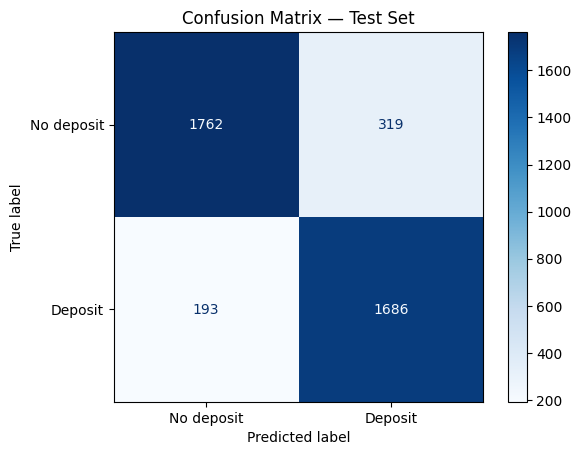

In [59]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No deposit", "Deposit"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Test Set")
plt.show()


With the previous matrix we can observe that we get a high accuracy for both classes, thus suggesting that we do not have a strong bias towards any of them. If we look at the recall metric, we can observe the following value:

$$\text{Recall}=\frac{1688}{1688+191}=0.898$$

This indicates that our model is able to correctly identify approximately 89.8% of the times where people suscribes a term deposit. If we calculate the precision metric, we get the following value:

$$\text{Precision}=\frac{1688}{1688+323}=0.839$$

This indicates that when our model predicts that a client is interested in suscribing a term deposit, it is correct approximately 83.9% of the times. However, as our problem is balanced we can focus on the accuracy metric, which is the one that we have been using until now to evaluate the performance of our models. Therefore we can select CatBoost with HPO as our final one for the competition and the way of getting the predictions in this dataset is the following one:

In [101]:
import joblib

X_comp = pd.read_pickle("bank_competition.pkl").reset_index(drop=True)

if "deposit" in X_comp.columns:
    X_comp = X_comp.drop(columns=["deposit"])

y_comp_pred = final_model.predict(X_comp)                  

preds_df = pd.DataFrame({
    "id": X_comp.index,       
    "deposit_pred": y_comp_pred, 
})

preds_df.to_csv("predictions_bank_competition.csv", index=False)


joblib.dump(final_model, "final_model_catboost_pipeline.joblib")
preds_df.head()

,id,deposit_pred
0,0,0
1,1,1
2,2,0
3,3,1
4,4,1


By default the predict function employs a threshold of 0.5 to convert predicted labels into a class label. If the problem would be imbalanced, it would be interesting to evaluate different thresholds to maximize a specific metric. However, as our problem is balanced, we can use the default threshold without any problem.

# 6. CALIBRATION OF PROBABILITES

After evaluating  our HP Optimized CatBoost performance, we would like to improve its probability calibration.
A miscalibrated model might show high accuracy but produce unreliable probability 
estimates, leading to poor decision-making.

We evaluate calibration using the following metrics:

- **ECE (Expected Calibration Error)**: Average difference between predicted 
  probabilities and observed frequencies across probability bins. Lower is better.
- **MECE (Maximum Expected Calibration Error)**: Worst-case calibration error 
  across all bins. Identifies the most miscalibrated region.
- **Brier Score**: Mean squared difference between predicted probabilities and 
  actual outcomes. Measures both calibration and refinement.
- **Log Loss**: Penalizes confident wrong predictions more heavily than Brier score.

So, we define a class 'CalibratorAnalyzer', which focuses on calibrating the predicted probabilities of a classification model using methods like Platt Scaling and Isotonic Regression. It also evaluates the calibration performance using metrics such as Brier Score and Log Loss, and visualizes the calibration curves.

In [119]:
class CalibrationAnalyzer:

    
    def __init__(self, pipeline, best_params, X_train, X_test, y_train, y_test, seed):
        self.pipeline = pipeline
        self.best_params = best_params
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.seed = seed

        # Train the best model
        self.best_model = clone(pipeline).set_params(**best_params)
        self.best_model.fit(self.X_train, self.y_train)

        # Get uncalibrated predictions
        self.y_prob_uncal = self.best_model.predict_proba(self.X_test)[:, 1]
        self.y_pred_uncal = self.best_model.predict(self.X_test)

        # Compute uncalibrated metrics
        self.acc_uncal = accuracy_score(self.y_test, self.y_pred_uncal)
        self.brier_uncal = brier_score_loss(self.y_test, self.y_prob_uncal)
        self.logloss_uncal = log_loss(self.y_test, self.y_prob_uncal)

        # Initialize results dictionary
        self.results = {"Uncalibrated": {}}
        self.results["Uncalibrated"]["Accuracy"] = self.acc_uncal
        self.results["Uncalibrated"]["Brier"] = self.brier_uncal
        self.results["Uncalibrated"]["LogLoss"] = self.logloss_uncal
        self.results["Uncalibrated"]["ECE"] = self.compute_ece(self.y_test, self.y_prob_uncal)
        self.results["Uncalibrated"]["MECE"] = self.compute_mece(self.y_test, self.y_prob_uncal)

        # Calibrated predictions (initially None)
        self.y_prob_iso = None
        self.y_prob_platt = None

    def compute_ece(self, y_true, y_prob, n_bins=10):
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy="uniform")
        bin_weights = np.array([1 / n_bins] * len(prob_true))
        return np.average(np.abs(prob_pred - prob_true), weights=bin_weights)

    def compute_mece(self, y_true, y_prob, n_bins=10):
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy="uniform")
        return np.max(np.abs(prob_pred - prob_true))

    def calibrate_isotonic(self):
        cv = KFold(n_splits=3, shuffle=True, random_state=self.seed)
        cal_iso = CalibratedClassifierCV(self.best_model, method="isotonic", cv=cv, ensemble=False)
        cal_iso.fit(self.X_train, self.y_train)
        self.y_prob_iso = cal_iso.predict_proba(self.X_test)[:, 1]
        y_pred_iso = cal_iso.predict(self.X_test)

        self.results["Isotonic"] = {}
        self.results["Isotonic"]["Accuracy"] = accuracy_score(self.y_test, y_pred_iso)
        self.results["Isotonic"]["Brier"] = brier_score_loss(self.y_test, self.y_prob_iso)
        self.results["Isotonic"]["LogLoss"] = log_loss(self.y_test, self.y_prob_iso)
        self.results["Isotonic"]["ECE"] = self.compute_ece(self.y_test, self.y_prob_iso)
        self.results["Isotonic"]["MECE"] = self.compute_mece(self.y_test, self.y_prob_iso)

    def calibrate_platt(self):
        cv = KFold(n_splits=3, shuffle=True, random_state=self.seed)
        cal_platt = CalibratedClassifierCV(self.best_model, method="sigmoid", cv=cv, ensemble=False)
        cal_platt.fit(self.X_train, self.y_train)
        self.y_prob_platt = cal_platt.predict_proba(self.X_test)[:, 1]
        y_pred_platt = cal_platt.predict(self.X_test)

        self.results["Platt"] = {}
        self.results["Platt"]["Accuracy"] = accuracy_score(self.y_test, y_pred_platt)
        self.results["Platt"]["Brier"] = brier_score_loss(self.y_test, self.y_prob_platt)
        self.results["Platt"]["LogLoss"] = log_loss(self.y_test, self.y_prob_platt)
        self.results["Platt"]["ECE"] = self.compute_ece(self.y_test, self.y_prob_platt)
        self.results["Platt"]["MECE"] = self.compute_mece(self.y_test, self.y_prob_platt)

    def plot_uncalibrated_analysis(self):

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Reliability diagram
        ax = axes[0]
        frac_pos, mean_pred = calibration_curve(self.y_test, self.y_prob_uncal, 
                                                 n_bins=10, strategy="uniform")
        ax.plot(mean_pred, frac_pos, 's-', color='tab:red', linewidth=2, 
                markersize=8, label=f"Uncalibrated (ECE={self.results['Uncalibrated']['ECE']:.3f})")
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label="Perfect calibration")
        ax.set_xlabel("Mean predicted probability", fontsize=11)
        ax.set_ylabel("Fraction of positives", fontsize=11)
        ax.set_title("Reliability Diagram - Uncalibrated Model", fontsize=12, fontweight='bold')
        ax.set_ylim([-0.05, 1.05])
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        
        # Histogram
        ax = axes[1]
        ax.hist(self.y_prob_uncal, bins=10, density=True, alpha=0.7,
                color='tab:red', edgecolor='black', linewidth=0.5)
        ax.set_xlabel("Predicted probabilities", fontsize=11)
        ax.set_ylabel("Density", fontsize=11)
        ax.set_title("Distribution of Predicted Probabilities", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()

    def reliability_plot(self, method="Uncalibrated"):

        colors = {"Uncalibrated": "tab:red", "Isotonic": "tab:green", "Platt": "tab:blue"}
        
        if method not in ["Uncalibrated", "Isotonic", "Platt"]:
            raise ValueError(f"method must be one of {list(colors.keys())}")
        
        if method == "Isotonic" and self.y_prob_iso is None:
            raise ValueError("Run calibrate_isotonic() first.")
        if method == "Platt" and self.y_prob_platt is None:
            raise ValueError("Run calibrate_platt() first.")

        # Select appropriate probabilities
        if method == "Uncalibrated":
            y_prob_cal = self.y_prob_uncal
            title = "Reliability Diagram - Uncalibrated Model"
        elif method == "Isotonic":
            y_prob_cal = self.y_prob_iso
            title = "Reliability Diagram - Isotonic vs Uncalibrated"
        else:
            y_prob_cal = self.y_prob_platt
            title = "Reliability Diagram - Platt Scaling vs Uncalibrated"

        fig, ax = plt.subplots(figsize=(7, 7))
        
        # Plot curves
        if method == "Uncalibrated":
            # Only plot uncalibrated
            frac_pos, mean_pred = calibration_curve(self.y_test, self.y_prob_uncal, 
                                                     n_bins=10, strategy="uniform")
            ax.plot(mean_pred, frac_pos, 's-', color=colors["Uncalibrated"], linewidth=2,
                    markersize=8, label=f"Uncalibrated (ECE={self.results['Uncalibrated']['ECE']:.3f})")
        else:
            # Plot both uncalibrated and calibrated
            for name, y_prob in [("Uncalibrated", self.y_prob_uncal), (method, y_prob_cal)]:
                frac_pos, mean_pred = calibration_curve(self.y_test, y_prob, 
                                                         n_bins=10, strategy="uniform")
                ax.plot(mean_pred, frac_pos, 's-', color=colors[name], linewidth=2,
                        markersize=8, label=f"{name} (ECE={self.results[name]['ECE']:.3f})")

        ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label="Perfect calibration")
        ax.set_xlabel("Mean predicted probability", fontsize=11)
        ax.set_ylabel("Fraction of positives", fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylim([-0.05, 1.05])
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

    def histogram_plot(self, method="Isotonic"):

        colors = {"Uncalibrated": "tab:red", "Isotonic": "tab:green", "Platt": "tab:blue"}
        
        if method == "Isotonic" and self.y_prob_iso is None:
            raise ValueError("Run calibrate_isotonic() first.")
        if method == "Platt" and self.y_prob_platt is None:
            raise ValueError("Run calibrate_platt() first.")

        y_prob_cal = self.y_prob_iso if method == "Isotonic" else self.y_prob_platt
        title = f"Probability Distribution - {method} vs Uncalibrated"

        fig, ax = plt.subplots(figsize=(8, 5))
        ax.hist(self.y_prob_uncal, bins=50, density=True, alpha=0.6,
                color=colors["Uncalibrated"], label="Uncalibrated", edgecolor='black', linewidth=0.5)
        ax.hist(y_prob_cal, bins=50, density=True, alpha=0.6,
                color=colors[method], label=method, edgecolor='black', linewidth=0.5)
        ax.set_xlabel("Predicted probabilities", fontsize=11)
        ax.set_ylabel("Density", fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

    def metrics_table(self, methods=None):

        if methods is None:
            methods = list(self.results.keys())
        
        df = pd.DataFrame(self.results).T.loc[methods].round(4)
        return df

    def print_metrics(self, method="Uncalibrated"):

        if method not in self.results:
            raise ValueError(f"Method {method} not found. Available: {list(self.results.keys())}")
        
        print(f"\n{'='*50}")
        print(f"  {method} Model - Calibration Metrics")
        print(f"{'='*50}")
        for metric, value in self.results[method].items():
            print(f"  {metric:.<20} {value:.4f}")
        print(f"{'='*50}\n")


    def compare_all_methods(self):

        available_methods = list(self.results.keys())
        colors = {"Uncalibrated": "tab:red", "Isotonic": "tab:green", "Platt": "tab:blue"}
        
        fig, ax = plt.subplots(figsize=(8, 8))
        
        for method in available_methods:
            if method == "Uncalibrated":
                y_prob = self.y_prob_uncal
            elif method == "Isotonic":
                y_prob = self.y_prob_iso
            elif method == "Platt":
                y_prob = self.y_prob_platt
            else:
                continue
                
            frac_pos, mean_pred = calibration_curve(self.y_test, y_prob, 
                                                     n_bins=10, strategy="uniform")
            ax.plot(mean_pred, frac_pos, 's-', color=colors[method], linewidth=2,
                    markersize=8, label=f"{method} (ECE={self.results[method]['ECE']:.3f})")
        
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label="Perfect calibration")
        ax.set_xlabel("Mean predicted probability", fontsize=11)
        ax.set_ylabel("Fraction of positives", fontsize=11)
        ax.set_title("Calibration Comparison - All Methods", fontsize=12, fontweight='bold')
        ax.set_ylim([-0.05, 1.05])
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

In [120]:
# Initialize calibration analyzer with best model
best_params["classifier__thread_count"] = -1

analyzer = CalibrationAnalyzer(
    pipeline=cat_pipeline,
    best_params=best_params,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    seed=SEED,
)


Before applying any calibration corrections, we first establish the baseline performance of our optimized CatBoost classifier. Modern gradient boosting frameworks, particularly CatBoost, optimize the log-loss objective function during training, which theoretically encourages the production of well-calibrated probabilities. However, the degree of calibration achieved depends on various factors including model complexity, dataset characteristics, and the presence of class imbalance. [Historical research](https://arxiv.org/pdf/1207.1403) documented that boosted decision trees often exhibit poor calibration, particularly when trained with exponential loss functions. More recent implementations like CatBoost, which directly optimize log-loss and incorporate sophisticated regularization mechanisms, have shown improved calibration properties compared to earlier boosting methods.

## Uncalibrated Model

In [121]:
display(analyzer.metrics_table(methods=["Uncalibrated"]))

,Accuracy,Brier,LogLoss,ECE,MECE
Uncalibrated,0.8707,0.0967,0.3184,0.0368,0.0986


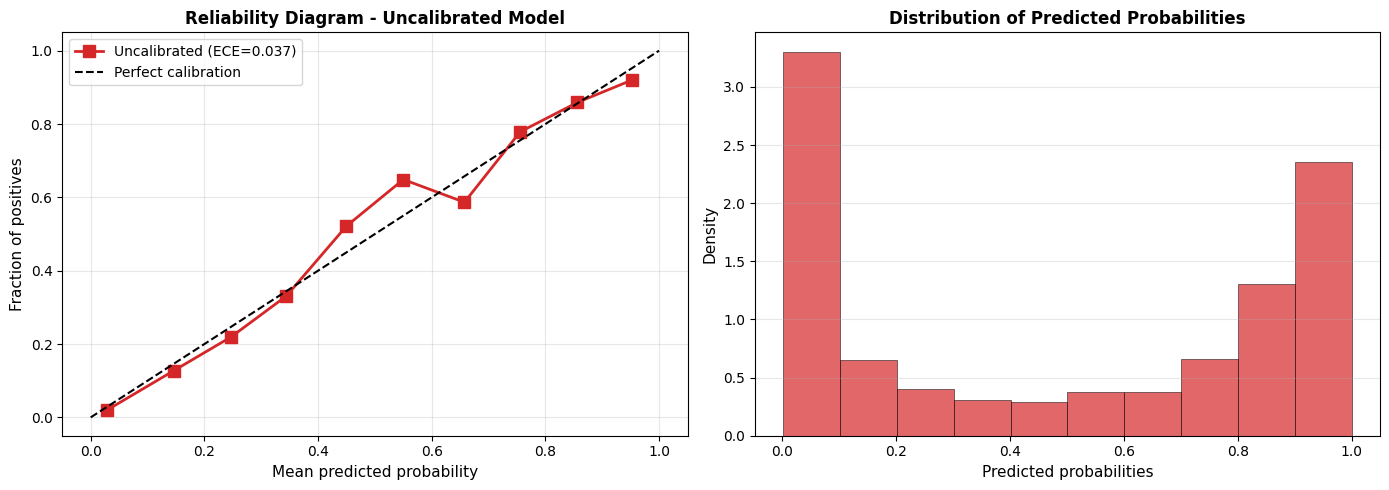

In [122]:
# Visualize uncalibrated model calibration
analyzer.plot_uncalibrated_analysis()

Our analysis reveals that the uncalibrated CatBoost model demonstrates remarkably strong baseline calibration. With an ECE of 0.037, the model falls well below the commonly accepted threshold of 0.05 for considering a classifier well-calibrated. The reliability diagram confirms this finding, showing that predicted probabilities closely track the diagonal line representing perfect calibration. The maximum calibration error of approximately 0.10 occurs in a localized probability range, suggesting that while the overall calibration is excellent, there remain minor systematic deviations in specific prediction regions. This baseline performance raises an important question: whether additional calibration methods will yield meaningful improvements, or if they might introduce unnecessary complexity and potentially degrade the already strong calibration quality.

## Platt Scaling Calibration

Platt scaling, introduced by John Platt, applies logistic regression to transform uncalibrated model outputs into calibrated probabilities. The method assumes that miscalibration follows a sigmoidal pattern that can be corrected through a parametric transformation defined by two parameters: a slope and an intercept.

 This parametric approach offers computational efficiency and robustness when calibration data is limited, making it particularly suitable for scenarios with fewer than 1000 calibration samples. Platt scaling works optimally when the underlying miscalibration exhibits a smooth, monotonic relationship between predicted and true probabilities, such as systematic overconfidence or underconfidence across the entire probability spectrum.


In [123]:
# Apply Platt scaling calibration
analyzer.calibrate_platt()


In [124]:
# Compare metrics
display(analyzer.metrics_table(methods=["Uncalibrated", "Platt"]))

,Accuracy,Brier,LogLoss,ECE,MECE
Uncalibrated,0.8707,0.0967,0.3184,0.0368,0.0986
Platt,0.8697,0.0979,0.3251,0.0635,0.1511


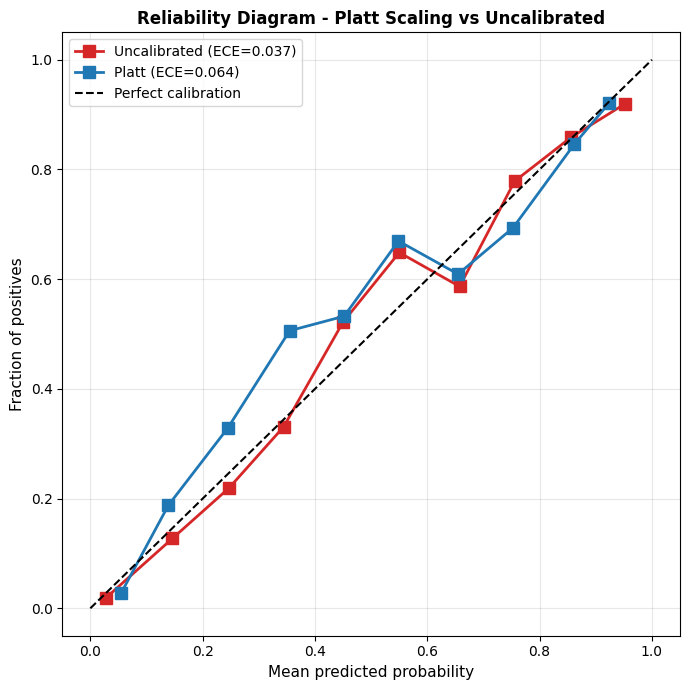

In [125]:
# Visualize Platt calibration
analyzer.reliability_plot(method="Platt")

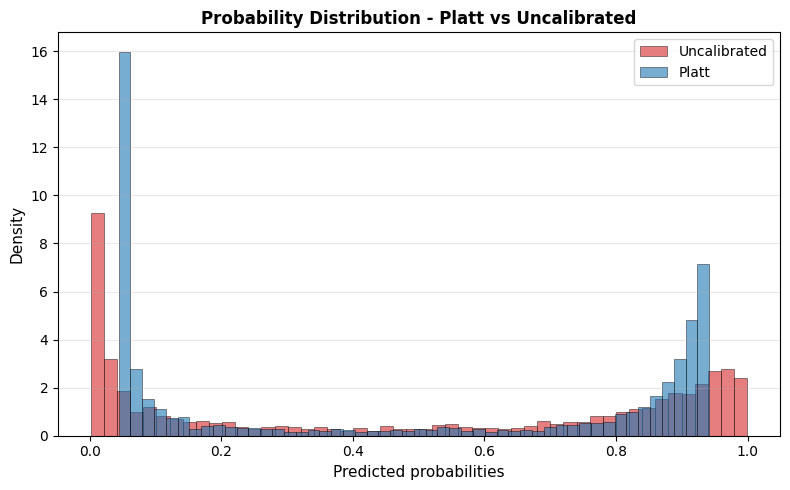

In [126]:
# Show probability distribution changes
analyzer.histogram_plot(method="Platt")

The application of Platt scaling to our CatBoost model produces unexpected results: calibration quality deteriorates rather than improves. The ECE increases from 0.037 to 0.064, while MECE rises from 0.099 to 0.151, indicating that Platt scaling introduces systematic errors where none previously existed. 

The reliability diagram illustrates this degradation clearly, with the calibrated curve deviating further from the diagonal, particularly in the mid-probability range between 0.5 and 0.7. This counterintuitive outcome occurs because Platt scaling assumes a sigmoidal miscalibration pattern that fundamentally does not exist in our well-calibrated baseline model. By imposing this structural assumption, the method introduces artificial distortions that worsen the probability estimates.

 The probability distribution histogram further reveals that Platt scaling pushes predictions toward more extreme values near zero, creating a more polarized distribution that reduces calibration quality. This result underscores an important principle: calibration methods designed to correct systematic miscalibration can be detrimental when applied to models that are already properly calibrated.


## Isotonic Regression Calibration

Isotonic regression represents a non-parametric approach to probability calibration that learns a monotonic, constant by intervals mapping from uncalibrated to calibrated probabilities. Unlike Platt scaling, isotonic regression makes no assumptions about the functional form of miscalibration, allowing it to adapt flexibly to complex, non-linear calibration patterns. The method works by finding the monotonic function that minimizes the squared error between predicted and observed probabilities while preserving the ranking of predictions. This flexibility makes isotonic regression particularly effective for correcting irregular miscalibration patterns that cannot be adequately addressed by parametric methods. 

However, this flexibility comes at a cost: isotonic regression requires larger calibration datasets to avoid overfitting, with most articles recommending at least 1000 calibration samples for reliable performance.


In [127]:
# Apply Isotonic regression calibration
analyzer.calibrate_isotonic()


In [128]:
# Compare metrics
display(analyzer.metrics_table(methods=["Uncalibrated", "Isotonic"]))

,Accuracy,Brier,LogLoss,ECE,MECE
Uncalibrated,0.8707,0.0967,0.3184,0.0368,0.0986
Isotonic,0.8727,0.0967,0.3249,0.0288,0.0891


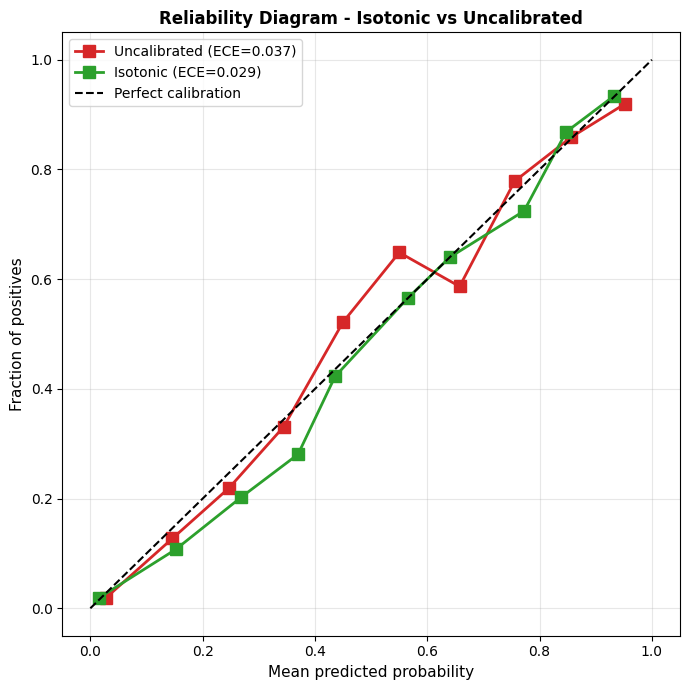

In [129]:
# Visualize Isotonic calibration
analyzer.reliability_plot(method="Isotonic")

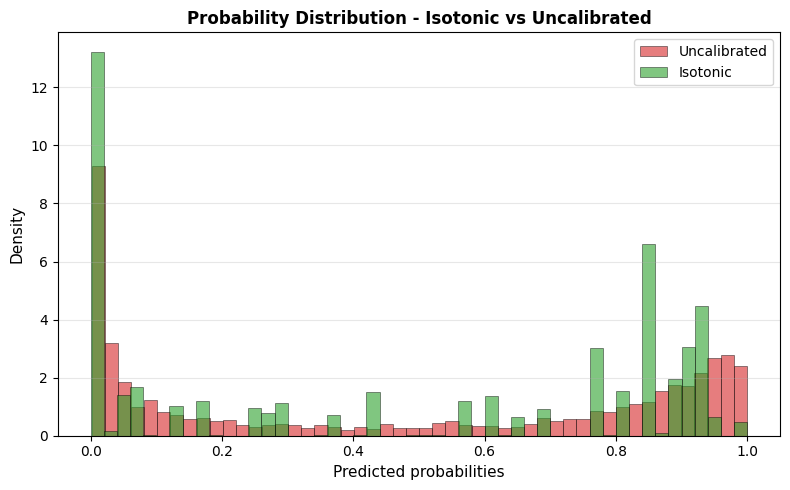

In [130]:
# Show probability distribution changes
analyzer.histogram_plot(method="Isotonic")

The application of isotonic regression to our model yields modest improvements over the uncalibrated baseline. ECE decreases from 0.037 to 0.029, and MECE improves from 0.099 to 0.089, demonstrating that the method successfully identifies and corrects subtle non-linearities in the calibration curve. The reliability diagram shows that isotonic regression brings the calibration curve slightly closer to the ideal diagonal, particularly in regions where the uncalibrated model exhibited minor deviations.

However, we observe that Log Loss increases marginally from 0.318 to 0.325, suggesting a slight degradation in the sharpness of probability predictions. This trade-off reflects a fundamental tension in calibration: improving the alignment between predicted and observed frequencies can sometimes come at the expense of predictive discrimination. The small magnitude of improvement raises questions about whether this marginal gain justifies the additional complexity of deploying a calibrated model in production environments.


## Calibration Comparisons

In [131]:
display(analyzer.metrics_table())

,Accuracy,Brier,LogLoss,ECE,MECE
Uncalibrated,0.8707,0.0967,0.3184,0.0368,0.0986
Platt,0.8697,0.0979,0.3251,0.0635,0.1511
Isotonic,0.8727,0.0967,0.3249,0.0288,0.0891


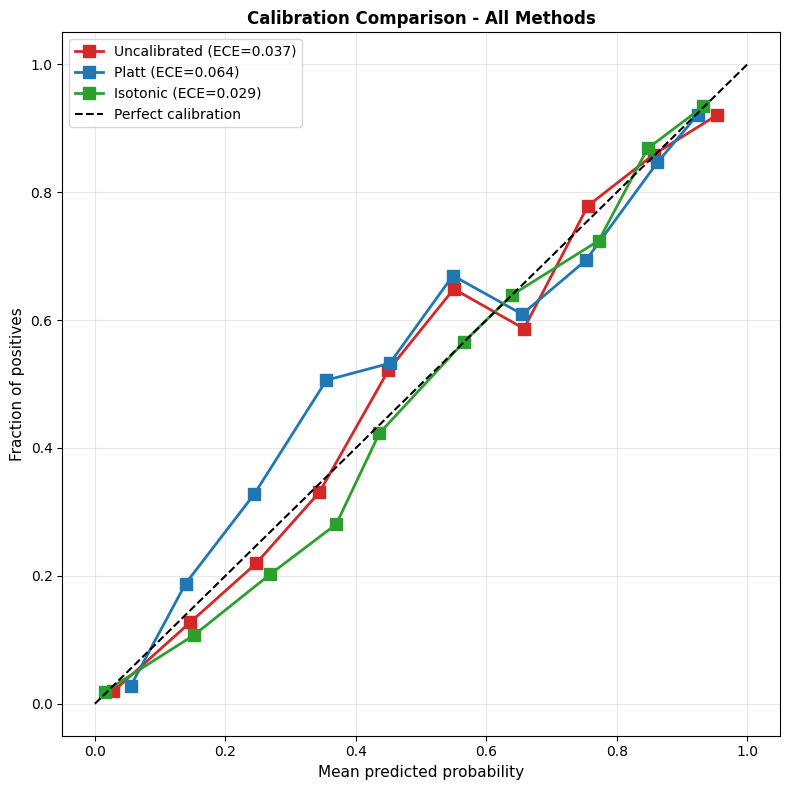

In [132]:
# Visual comparison
analyzer.compare_all_methods()

In practice, only limited improvements are often observed when applying post-hoc probability calibration to CatBoost models. This is largely because CatBoost is typically trained by directly optimizing a proper scoring rule such as log-loss, which already encourages well-calibrated probability estimates. Moreover, CatBoost’s internal design tends to reduce overfitting and extreme score distortions that commonly harm calibration in other boosting methods. As a result, CatBoost frequently produces probability estimates that are already close to well calibrated, leaving little room for additional gains from external calibration techniques such as Platt scaling or isotonic regression, although this behavior remains dataset-dependent rather than guaranteed.


Based on this evaluation, we still recommend deploying the **Uncalibrated CatBoost Model** for the future predicting usage. While Isotonic Regression technically achieves better calibration benchmarks, the small marginal improvement in those does not justify the operationl complexity of improving the model's calibration; particularly given the excellent baseline performance. 

The degradation observed with Platt scaling serves as an important reminder that calibration methods should not be applied reflexively; rather, practitioners must first assess baseline calibration quality and only deploy correction methods when substantial miscalibration is evident.

# 7. OPEN CHOICE TASK

In this section we try some additional tasks to try to improve the results obtained until now. The tasks that we are going to try are the following ones:
- Feature Selection
- Support Vector Machines (SVM)
- Another Boosting Method: AdaBoost
- Stacking Method

We belive that feature selection can be crucial because our datasey may contain some noisy or redundant features that could be confusing our model. if we remove them, we believe that we can reduce the variance and improve the generalization of our model.

We also evaluate the preformance of Support Vector Machines since in this [page](https://scikit-learn.org/stable/machine_learning_map.html) we saw that Linear Support Vector Classification is the recommended algorithm for classification problems with fewer than 100,000 samples. Since our dataset fits this criterion, we consider that this implementation of SVM could help us to find a better decision boundary between our classes.

Also, Stacking might result in an even better model, as errors tend to compensate when using a variety of different models


## Feature Selection

In most machine learning problems, not all features are equally important. Some features can include some noise or redundancy to the models, which can lead to downgrade the generalization ability of a model, thus downgrading its performance on unseen data. Therefore, based on this [article](https://www.geeksforgeeks.org/machine-learning/feature-selection-in-python-with-scikit-learn/), we try to perfomr feature selection using different methods provided by scikit-learn.

### Tree-Based Feature Selection

Random and Decision Trees do not only provide predcitions, but also give us information about feature importance based on how much each feature contributes to make the prediction. Therefore, we can leverage this property to perform feature selection. We first train a Random Forest model with default hyperparameters and then we extract the feature importances.

In [27]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),    
    ('classifier', RandomForestClassifier(random_state=SEED))
])

model.fit(X_train, y_train)
pre = model.named_steps["preprocessor"]
feature_names = []

for name, transformer, cols in pre.transformers_:
    if name == "remainder":
        continue
    if hasattr(transformer, "steps"):
        found = False
        for step_name, step_est in reversed(transformer.steps):
            if hasattr(step_est, "get_feature_names_out"):
                fn = step_est.get_feature_names_out(cols)
                feature_names.extend(fn)
                found = True
                break

        if not found:
            if name == "dates":
                feature_names.extend(["day_of_year_sin", "day_of_year_cos"])
            else:
                feature_names.extend(cols)

    elif hasattr(transformer, "get_feature_names_out"):
        fn = transformer.get_feature_names_out(cols)
        feature_names.extend(fn)

    else:
        if name == "dates":
            feature_names.extend(["day_of_year_sin", "day_of_year_cos"])
        else:
            feature_names.extend(cols)

importances = model.named_steps["classifier"].feature_importances_

print("n_features_importances:", len(importances))
print("n_feature_names:", len(feature_names))

feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print(feature_importances)


n_features_importances: 38
n_feature_names: 38
duration             0.322676
day_of_year_cos      0.103095
day_of_year_sin      0.097418
balance              0.076209
age                  0.068358
pdays                0.035064
campaign             0.031254
poutcome_success     0.026953
education            0.024694
contact_unknown      0.023467
previous             0.020448
contact_cellular     0.017863
housing_yes          0.015327
housing_no           0.013781
poutcome_unknown     0.012140
marital_married      0.009092
job_blue-collar      0.008076
job_management       0.007948
marital_single       0.007768
job_technician       0.007750
job_admin.           0.007130
loan_no              0.006989
poutcome_failure     0.006240
loan_yes             0.005829
marital_divorced     0.005193
job_services         0.005121
job_student          0.004206
contact_telephone    0.004200
job_retired          0.003988
poutcome_other       0.003612
job_unemployed       0.003300
job_self-employed    0.

Now, in order to see the importance of every feature, we group the different importances of the original features. For example, the feature `job` was one-hot encoded into 12 different binary features. Therefore, we sum the importances of these 12 features to get the overall importance of the original `job` feature. We do this for every categorical feature that was encoded.

In [28]:
def map_to_original_feature(feature_name):

    if feature_name.startswith("housing_"):
        return "housing"
    if feature_name.startswith("loan_"):
        return "loan"
    if feature_name.startswith("contact_"):
        return "contact"
    if feature_name.startswith("poutcome_"):
        return "poutcome"
    if feature_name.startswith("job_"):
        return "job"
    if feature_name.startswith("marital_"):
        return "marital"

    if feature_name in ["day_of_year_sin", "day_of_year_cos"]:
        return "date"
    if feature_name.startswith("default_"):
        return "default"
    return feature_name


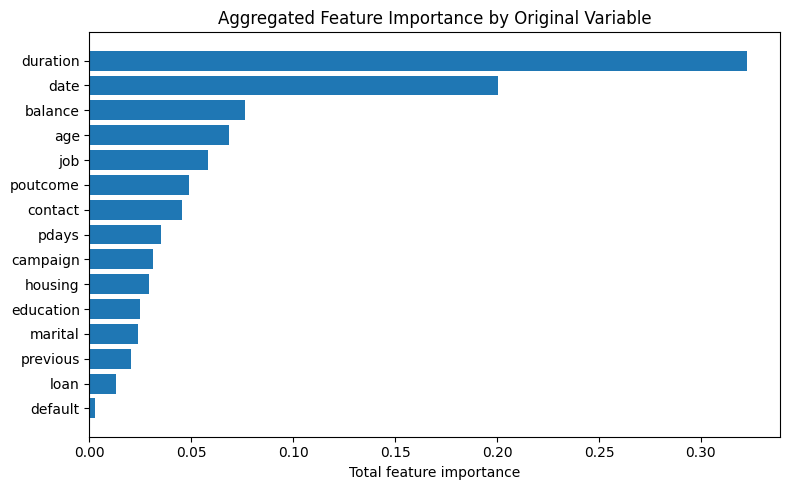

In [30]:
importance_df = feature_importances.reset_index()
importance_df.columns = ["feature", "importance"]

importance_df["original_feature"] = importance_df["feature"].apply(map_to_original_feature)

grouped_importance = (
    importance_df
    .groupby("original_feature", as_index=False)["importance"]
    .sum()
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8, 5))
plt.barh(
    grouped_importance["original_feature"][::-1],
    grouped_importance["importance"][::-1]
)
plt.xlabel("Total feature importance")
plt.title("Aggregated Feature Importance by Original Variable")
plt.tight_layout()
plt.show()


From the previous cell, we can conclude that there are many features that contribute less than 2.5% to the model’s feature importance. If we sum these features, we can see that they contribute approximately 8.5% of the total importance. Therefore, we believe that removing these features could help us to reduce the noise and improve the generalization of our model. The features that we are going to remove are the following ones:

In [60]:
thr = 0.025  # 0.5%
cols_to_drop = grouped_importance[grouped_importance["importance"] < thr]["original_feature"].tolist()
cols_keep = [c for c in grouped_importance["original_feature"] if c not in cols_to_drop]

print("Total features:", len(grouped_importance))
print("Features removed:", len(cols_to_drop))
print("Total importance removed:", sum(grouped_importance["importance"][grouped_importance["importance"] < thr]))
print("Features kept:", len(cols_keep))
print("Features removed:", cols_to_drop)

Total features: 15
Features removed: 5
Total importance removed: 0.08437365395114764
Features kept: 10
Features removed: ['education', 'marital', 'previous', 'loan', 'default']


In [44]:
X_train_red = X_train.drop(columns=cols_to_drop, errors="ignore")
X_test_red  = X_test.drop(columns=cols_to_drop, errors="ignore")
print("X_train_red shape:", X_train_red.shape)

X_train_red shape: (7040, 11)


As we are have deleted some features, we need to create a new preprocessibng pipeline without those features. If we would not do this, we would get an error when trying to fit the model because the number of features would not match. To this end, we first implemen a new function that removes the unwanted features from the dataset using the arrays we defined during the decision tree preprocessing.

In [45]:
def keep_existing(cols, X):
    return [c for c in cols if c in X.columns]

num_features_red        = keep_existing(num_features, X_train_red)
onehot_features_red     = keep_existing(onehot_features, X_train_red)
job_features_red        = keep_existing(job_features, X_train_red)
marital_features_red    = keep_existing(marital_features, X_train_red)
date_cols_red           = keep_existing(date_cols, X_train_red)
education_features_red  = keep_existing(education_features, X_train_red)

In [46]:
preprocessor_tree_red = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ]), num_features_red),

        ('onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), onehot_features_red),

        ('education', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('encode', OrdinalEncoder(categories=education_order,
                                     handle_unknown='use_encoded_value',
                                     unknown_value=-1))
        ]), education_features_red),

        ('job', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), job_features_red),

        ('dates', date_pipeline, date_cols_red),

        ('marital', marital_pipeline, marital_features_red),
    ],
    remainder='drop'
)

After this we perform again a hyperparameter optimization for the final model, which is CatBoost, because the hyperparameters could change after removing some features. After this we evaluate the performance of this new model on the test set.

In [50]:
reduced_model = Pipeline(steps=[
    ('preprocessor', preprocessor_tree_red),
    ('classifier', CatBoostClassifier(random_seed=SEED,verbose=0,loss_function="Logloss",allow_writing_files=False))
])

cat_reduced_hpo = OptunaSearch_CatBoost(reduced_model, n_trials=50)

start = time.time()
cat_reduced_hpo.fit(X_train_red, y_train)
end = time.time()

inner_scores["catboost_reduced_hpo_optuna_search"] = cat_reduced_hpo.best_score_
timers_models["catboost_reduced_hpo_optuna_search"] = end - start

print("CatBoost Optuna best score:", inner_scores["catboost_reduced_hpo_optuna_search"])
print("CatBoost Optuna best params:", cat_reduced_hpo.best_params_)
print("Time:", timers_models["catboost_reduced_hpo_optuna_search"])



[I 2025-12-18 16:10:23,428] A new study created in memory with name: no-name-469e499f-0306-4789-9dde-2e78cd4fcaa9


[I 2025-12-18 16:10:26,607] Trial 0 finished with value: 0.864346590909091 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__education__imputer': 'most_frequent', 'preprocessor__job__imputer': 'constant', 'preprocessor__marital__imputer': 'constant', 'classifier__iterations': 500, 'classifier__depth': 7, 'classifier__l2_leaf_reg': 4.524157201932811, 'classifier__random_strength': 1.4360573880488803, 'classifier__bagging_temperature': 0.9972010344110641, 'classifier__border_count': 200, 'classifier__grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.864346590909091.
[I 2025-12-18 16:10:27,287] Trial 1 finished with value: 0.8444602272727273 and parameters: {'preprocessor__dates__encode__func': 'identity', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preproc

CatBoost Optuna best score: 0.8694602272727272
CatBoost Optuna best params: {'preprocessor__dates__encode__func': <function identity_transform at 0x0000024DF2465940>, 'preprocessor__education__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__education__imputer': SimpleImputer(fill_value='unknown', strategy='constant'), 'preprocessor__job__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__marital__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'classifier__iterations': 500, 'classifier__depth': 10, 'classifier__l2_leaf_reg': 9.351120737086168, 'classifier__random_strength': 0.14773640300067759, 'classifier__bagging_temperature': 0.4087412112879858, 'classifier__border_count': 115, 'classifier__grow_policy': 'Lossguide'}
Time:

In [51]:
reduced_model.set_params(**cat_reduced_hpo.best_params_)
reduced_model.fit(X_train_red, y_train)

y_pred_red = reduced_model.predict(X_test_red)
y_proba_red = reduced_model.predict_proba(X_test_red)[:, 1]
acc_test_red = accuracy_score(y_test, y_pred_red)
acc_test = .8707
print(f"Reduced model test accuracy: {acc_test_red:.4%} (original: {acc_test:.4%})")

Reduced model test accuracy: 86.3384% (original: 87.0700%)


Despite the hyperparameter optimization phase, we can see that the performance of the model after perfoprming feature selection using trees has decreased slightly. Therefore, we can conclude that this feature selection method has not been useful in our case.

## Linear Support Vector Classification (SVC)

In te case of SVMs, we evaluate the performnance of a Linear Support Vector Classification (SVC) model, which according to this [page](https://scikit-learn.org/stable/machine_learning_map.html) is suitbale for datasets with less than 100,000 samples. We first evaluate the default hyperparameters and then we perform hyperparameter optimization using Optuna. The key [hyperparameters](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) of this model are:

- `C`: This is a regularization parameter that controls the trade-off between achieving a low training error and a low testing error. A smaller value of C creates a larger margin hyperplane, which can lead to better generalization but may increase training error. The default value is [1.0](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). Int his [page](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html#sphx-glr-auto-examples-svm-plot-svm-scale-c-py) we read that C is very sensitive to the amount of data we have, so the optimal C value we get during hyperparameter optimization may not generalize well when using the whole dataset. By the way, we test the performance of the model to evaluate if its performance could potentially beat our final model.

- `class_weight`: This hyperparameter allows us to assign different weights to different classes. However, this is useful for imbalanced datasets, which is not our case. In scikit-learn, the default value is None, which means that all classes are supposed to have weight one. However, we can set this parameter to 'balanced', which adjust the weights inversely proportional to class frequencies in the input data.

- `loss`: The hyperparameter specifies the loss function the algorithm employs. By defualt, it is set to 'squared_hinge', which is a smooth version of the hinge loss that is commonly used in SVMs. However, we can also set it to 'hinge', which is the standard hinge loss.

- 

In this case we do not have to optimize the main hyperparameter of SVMs, the kernel. This implementation employs a linear kernel, which according this [scikit-learn page](https://scikit-learn.org/stable/modules/svm.html#classification) is capable to perform binary classification. As SVMs are affected by the scale of the data, we need to reuse the preprocessing pipeline that we created for KNN, which includes a scaling step.

In [90]:
from sklearn.svm import LinearSVC

svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_knn),
    ('classifier', LinearSVC(random_state=SEED,max_iter=100000))
])
svc_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
start_time = time.time()
scores=cross_val_score(svc_pipeline, X_train, y_train, cv=inner, scoring='accuracy', n_jobs=-1).mean()
end_time = time.time()
timers_models['svc_default'] = end_time - start_time
inner_scores['svc_default'] = scores
print("SVC CV Accuracy Results:")
print(scores)
print("Training time:")
print(f"{timers_models['svc_default']} seconds")

SVC CV Accuracy Results:
0.7678977272727272
Training time:
3.704281806945801 seconds


In [88]:
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

class OptunaSearch_LinearSVC(OptunaSearchBase):
    def __init__(self, svc_pipeline, n_trials=50):
        super().__init__(svc_pipeline, n_trials)

        # we reuse this from KNN
        self.preprocessing_config['num_scalers'] = {
            'standard': StandardScaler(),
            'robust': RobustScaler(),
            'minmax': MinMaxScaler(),
        }

    def objective(self, trial, X_train, y_train):
        super().objective(trial, X_train, y_train)

        scaler_key = trial.suggest_categorical(
            "preprocessor__num__scaler",
            list(self.preprocessing_config['num_scalers'].keys())
        )

        C = trial.suggest_float("classifier__C", 1e-6, 100, log=True)
        loss = trial.suggest_categorical("classifier__loss", ["hinge", "squared_hinge"])
        class_weight = trial.suggest_categorical("classifier__class_weight", [None, "balanced"])


        self.model.set_params(
            preprocessor__num__scaler=self.preprocessing_config['num_scalers'][scaler_key],
            classifier__C=C,
            classifier__loss=loss,
            classifier__class_weight=class_weight,
        )

        scores = cross_val_score(
            self.model,
            X_train, y_train,
            cv=inner,
            scoring="accuracy",
            n_jobs=-1
        )
        return scores.mean()

    def decode_params(self, params):
        params = super().decode_params(params)
        params['preprocessor__num__scaler'] = self.preprocessing_config['num_scalers'][params['preprocessor__num__scaler']]
        return params


In [91]:
optuna_svc = OptunaSearch_LinearSVC(svc_pipeline, n_trials=50)
optuna_svc.fit(X_train, y_train)

print("Best score:", optuna_svc.best_score_)
print("Best params:", optuna_svc.best_params_)


[I 2025-12-18 16:53:42,576] A new study created in memory with name: no-name-5e415898-a9d7-4283-80f8-e210ac34953c
[I 2025-12-18 16:53:46,357] Trial 0 finished with value: 0.8072443181818182 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__num__scaler': 'standard', 'classifier__C': 0.06609084442044724, 'classifier__loss': 'squared_hinge', 'classifier__class_weight': 'balanced'}. Best is trial 0 with value: 0.8072443181818182.
[I 2025-12-18 16:53:48,858] Trial 1 finished with value: 0.8089488636363636 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ohe', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ord', 'preprocessor__num__scaler': 'minmax', 'classifier__C': 35.898383464162045, 'classifier__loss': 'hinge', 'classifier__class_weight': 'balanced'}. Best is trial 1

Best score: 0.8106534090909092
Best params: {'preprocessor__dates__encode__func': <function cyclical_transform_365 at 0x0000024DF2465A80>, 'preprocessor__education__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__job__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__marital__encode': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__num__scaler': StandardScaler(), 'classifier__C': 1.5465810092163483, 'classifier__loss': 'hinge', 'classifier__class_weight': 'balanced'}


After performing the hyperparameter optimization, we do not evaluate the performance of this model on the test set because its performance during the inner cross-validation is much lower than the one obtained by our final model.

## Ada Boost

AdaBoostClassifier is a boosting method that builds an ensemble of weak learners, typically shallow decision trees, where each new learner focuses more on the instances that previous learners misclassified. The final prediction is obtained by combining the weighted votes of all weak learners. As with the other models, we first evaluate the default hyperparameters and then perform hyperparameter optimization using Optuna.

The key hyperparameters of this model are:​

- `estimator`: The weak learner used in the ensemble. By default, AdaBoost uses a DecisionTreeClassifier with max_depth=1, i.e., decision stumps.​

- `n_estimators`: The maximum number of weak learners in the ensemble. Larger values allow more complex ensembles but may increase overfitting and training time. The default value is 50.​

- `learning_rate`: A shrinkage parameter that scales the contribution of each weak learner. There is a trade-off between learning_rate and n_estimators; lower learning rates usually require more estimators. The default value is 1.0.​

- `algorithm`: Specifies the boosting algorithm. 'SAMME.R' is the default and uses real-valued predictions, while 'SAMME' uses class labels and can be better for some multi-class problems.​

In [60]:
from sklearn.ensemble import AdaBoostClassifier

ada_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', AdaBoostClassifier(
        random_state=SEED
    ))
])

start = time.time()
ada_default_score = cross_val_score(
    ada_pipeline, X_train, y_train,
    cv=inner, scoring="accuracy", n_jobs=-1
).mean()
end = time.time()

inner_scores["adaboost_default"] = ada_default_score
timers_models["adaboost_default"] = end - start

print("AdaBoost default accuracy:", ada_default_score)
print("Time:", timers_models["adaboost_default"])


AdaBoost default accuracy: 0.8055397727272726
Time: 16.192870616912842


We now define the class for the posterior HPO:

In [80]:
class OptunaSearch_AdaBoost(OptunaSearch_AdvancedMethods):
    def __init__(self, model_pipeline, n_trials=50, random_state=SEED):
        super().__init__(model_pipeline, n_trials, random_state)

    def objective(self, trial, X_train, y_train):
        super().objective(trial, X_train, y_train)

        n_estimators = trial.suggest_int(
            "classifier__n_estimators", 50, 300, step=50
        )
        learning_rate = trial.suggest_float(
            "classifier__learning_rate", 0.01, 1.0, log=True
        )

        self.model.set_params(
            classifier__n_estimators=n_estimators,
            classifier__learning_rate=learning_rate,
            classifier__algorithm="SAMME"
        )

        scores = cross_val_score(
            self.model, X_train, y_train,
            cv=inner, scoring="accuracy", n_jobs=-1
        )
        return scores.mean()


In [81]:
ada_hpo = OptunaSearch_AdaBoost(ada_pipeline, n_trials=50)

start = time.time()
ada_hpo.fit(X_train, y_train)
end = time.time()

inner_scores["adaboost_hpo_optuna_search"] = ada_hpo.best_score_
timers_models["adaboost_hpo_optuna_search"] = end - start

print("AdaBoost Optuna best score:", inner_scores["adaboost_hpo_optuna_search"])
print("AdaBoost Optuna best params:", ada_hpo.best_params_)
print("Time:", timers_models["adaboost_hpo_optuna_search"])


[I 2025-12-18 23:39:19,599] A new study created in memory with name: no-name-04058f78-c25a-4c3d-8bb4-e30926553d76


[I 2025-12-18 23:39:28,878] Trial 0 finished with value: 0.8036931818181818 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ord', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ohe', 'preprocessor__education__imputer': 'most_frequent', 'preprocessor__job__imputer': 'constant', 'preprocessor__marital__imputer': 'constant', 'classifier__n_estimators': 150, 'classifier__learning_rate': 0.1350248464714187}. Best is trial 0 with value: 0.8036931818181818.
[I 2025-12-18 23:39:32,407] Trial 1 finished with value: 0.8035511363636363 and parameters: {'preprocessor__dates__encode__func': 'cyclical', 'preprocessor__education__encode': 'ohe', 'preprocessor__job__encode': 'ohe', 'preprocessor__marital__encode': 'ord', 'preprocessor__education__imputer': 'most_frequent', 'preprocessor__job__imputer': 'constant', 'preprocessor__marital__imputer': 'most_frequent', 'classifier__n_estimators': 150, 'classifier__learning_rate': 

AdaBoost Optuna best score: 0.8318181818181818
AdaBoost Optuna best params: {'preprocessor__dates__encode__func': <function identity_transform at 0x000001B9DC8C67A0>, 'preprocessor__education__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__job__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__marital__encode': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__education__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__job__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'preprocessor__marital__imputer': SimpleImputer(fill_value='Unknown', strategy='constant'), 'classifier__n_estimators': 250, 'classifier__learning_rate': 0.9729201422803917}
Time: 264.1263437271118


## Stacking Model

Stacking is an [ensemble learning technique](https://scikit-learn.org/stable/modules/ensemble.html) that combines the predictions of several base models using a higher-level meta-model. Instead of simply averaging or voting over the base learners, stacking trains a second model (the meta-learner) that takes the base models’ predictions as inputs and learns how to weight and combine them optimally. In scikit-learn, this is implemented by the StackingClassifier, which behaves like any other estimator with fit and predict methods.​

The [key idea](https://www.emergentmind.com/topics/stacked-ensemble-learning-framework) is to use diverse base learners that capture different patterns in the data, such as distance-based methods, single decision trees, bagging ensembles, and gradient boosting models. Their out-of-sample predictions are then stacked and used as features for the meta-learner, typically a simple but strong model such as logistic regression. This framework often leads to better generalization than any individual model because the meta-learner can exploit complementary strengths and reduce the variance of the final predictions

In [75]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Build base models with best hyperparameters found

knn_best = clone(knn_pipeline)
knn_best.set_params(**{
    "preprocessor__dates__encode__func": identity_transform,
    "preprocessor__education__encode": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    "preprocessor__job__encode": OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    "preprocessor__marital__encode": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    "preprocessor__num__scaler": StandardScaler(),
    "knn__n_neighbors": 9,
    "knn__weights": "uniform",
    "knn__p": 3,
})

tree_best = clone(tree_pipeline)
tree_best.set_params(**{
    "preprocessor__dates__encode__func": identity_transform,
    "preprocessor__education__encode": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    "preprocessor__job__encode": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    "preprocessor__marital__encode": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    "preprocessor__education__imputer": SimpleImputer(strategy="most_frequent"),
    "preprocessor__job__imputer": SimpleImputer(fill_value="unknown", strategy="constant"),
    "preprocessor__marital__imputer": SimpleImputer(strategy="most_frequent"),
    "preprocessor__onehot__imputer": SimpleImputer(strategy="most_frequent"),
    "classifier__max_depth": 25,
    "classifier__min_samples_split": 62,
    "classifier__min_samples_leaf": 8,
    "classifier__criterion": "gini",
})

rf_best = clone(random_forest_pipeline)
rf_best.set_params(**{
    "preprocessor__dates__encode__func": identity_transform,
    "preprocessor__education__encode": OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    "preprocessor__job__encode": OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    "preprocessor__marital__encode": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    "preprocessor__education__imputer": SimpleImputer(strategy="most_frequent"),
    "preprocessor__job__imputer": SimpleImputer(strategy="most_frequent"),
    "preprocessor__marital__imputer": SimpleImputer(fill_value="Unknown", strategy="constant"),
    "classifier__max_depth": 38,
    "classifier__min_samples_split": 14,
    "classifier__min_samples_leaf": 2,
    "classifier__criterion": "gini",
    "classifier__n_estimators": 150,
    "classifier__bootstrap": False,
    "classifier__max_features": "sqrt",
})

cat_best = clone(cat_pipeline)
cat_best.set_params(**{
    "preprocessor__dates__encode__func": identity_transform,
    "preprocessor__education__encode": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    "preprocessor__job__encode": OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    "preprocessor__marital__encode": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    "preprocessor__education__imputer": SimpleImputer(strategy="most_frequent"),
    "preprocessor__job__imputer": SimpleImputer(strategy="most_frequent"),
    "preprocessor__marital__imputer": SimpleImputer(fill_value="Unknown", strategy="constant"),
    "classifier__iterations": 600,
    "classifier__depth": 10,
    "classifier__l2_leaf_reg": 4.698198315889567,
    "classifier__random_strength": 1.942942935278962,
    "classifier__bagging_temperature": 0.7584173465891255,
    "classifier__border_count": 239,
    "classifier__grow_policy": "Lossguide",
})


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('pdays', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


We use **Logistic Regression** as meta-learner, which takes the base models’ predictions as inputs and learns optimal linear weights to combine them, acting as a low-variance model that reduces overfitting in the final ensemble.

In [76]:
# Create the stacking model

stacking_clf = StackingClassifier(
    estimators=[
        ("knn", knn_best),
        ("tree", tree_best),
        ("rf", rf_best),
        ("cat", cat_best),
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=SEED),
    cv=inner,
    n_jobs=-1,
    passthrough=False,
)

In [77]:
# Evaluation

start = time.time()
stacking_score = cross_val_score(
    stacking_clf, X_train, y_train,
    cv=inner, scoring="accuracy", n_jobs=-1
).mean()
end = time.time()

inner_scores["stacking"] = stacking_score
timers_models["stacking"] = end - start

print("Stacking accuracy:", stacking_score)
print("Time:", timers_models["stacking"])

Stacking accuracy: 0.8704545454545454
Time: 211.90966057777405


And we visualize the different accuracies throughout our models again:

In [86]:
df_results = (
    pd.DataFrame({
        "Model": inner_scores.keys(),
        "Accuracy": inner_scores.values(),
        "Time (s)": [timers_models.get(m, None) for m in inner_scores.keys()]
    })
    .sort_values("Accuracy", ascending=False)
    .reset_index(drop=True)
)

df_results = df_results[[ "Model", "Accuracy", "Time (s)"]]

### Here we have used ChatGPT to help with the styling of the dataframe display

def highlight_top1(row):
    is_top = row.name == 0
    return [
        "background-color: #FFD700; font-weight: bold ; color: black" if is_top else ""
        for _ in row
    ]


df_results.style \
    .format({
        "Accuracy": "{:.4f}",
        "Time (s)": "{:.1f}"
    }) \
    .background_gradient(cmap="Greens", subset=["Accuracy"]) \
    .set_properties(**{
        "text-align": "center",
        "font-size": "13pt"
    }) \
    .set_table_styles([
        {"selector": "th", "props": [("font-size", "14pt"), ("text-align", "center")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16pt")]}
    ]) \
    .apply(highlight_top1, axis=1) \
    .set_caption("Inner CV Accuracy and Training Time of different models")


,Model,Accuracy,Time (s)
0,catboost_hpo_optuna_search,0.8705,726.5
1,stacking,0.8705,211.9
2,lgbm_hpo_optuna_search,0.8688,1627.9
3,hist_gradient_boosting_hpo_optuna_search,0.8685,218.5
4,catboost_default,0.8682,12.4
5,lgbm_default,0.8668,7.9
6,xgb_hpo_optuna_search,0.8662,79.7
7,hist_gradient_boosting_default,0.8653,7.0
8,gb_hpo_optuna_search,0.8634,477.9
9,random_forest_hpo_optuna_search,0.8584,115.2


In the previous table we can observe that when we use a stacking model, ca can achieve the same accuracy as with CatBoost with HPO. Therefore, we could also select this stacking model as our final model. However, as CatBoost is a single model, we prefer to keep CatBoost as our final model for simplicity and efficiency.